In [0]:
displayHTML('''
<center><br> <img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Amazon_2024.svg" style="width: 200px;"></center><br>
''')

In [0]:
displayHTML('''
<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #d9345b;">BDA Project |</span> <span style="color: #2a2a83;">Sentiment Analysis on Amazon Reviews of Electronics</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>João Henriques, 20240499</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>
''')

BDA Project | Sentiment Analysis on Amazon Reviews of Electronics 
 
 
 Spring Semester | 2024 - 2025
 
 
 Master in Data Science and Advanced Analytics
 
 
 André Silvestre, 20240502 
 Filipa Pereira, 20240509 
 João Henriques, 20240499 
 Umeima Mahomed, 20240543 
 
 
 Group 37

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 7px; color: white; border-radius: 500px; text-align: center;">
</div>

### **PySpark Session**

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session with optimized configurations
# Source: https://spark.apache.org/docs/latest/configuration.html
spark = (SparkSession.builder
         .appName("AmazonReviewsBigDataAnalytics_Clustering")
         .config("spark.driver.memory", "15g")              # Adjust memory for driver
         .config("spark.executor.memory", "15g")            # Adjust memory per executor
         .getOrCreate())

# Set Spark configurations for convert to Pandas without errors
# Source: https://stackoverflow.com/questions/47536123/collect-or-topandas-on-a-large-dataframe-in-pyspark-emr
#         https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## 📚 **Libraries Import**

In [0]:
# Install required libraries
!pip install tqdm

     |████████████████████████████████| 78 kB 3.4 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-dbb211c9-7bfa-4ff2-97ff-8495c3c318d8/bin/python -m pip install --upgrade pip' command.


In [0]:
# Imports for System Operations
import os
import sys
import time
import datetime

# Imports for Data Manipulation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Imports for Data Visualization
from math import ceil
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from IPython.display import display
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba_array, to_rgba

# Imports PySpark
from pyspark.sql.types import *
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.functions import when, col, rank

# Imports for Machine Learning (Clustering)
from pyspark.ml.feature import *
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline
from tqdm import tqdm           # Progress bar
from sklearn.metrics import silhouette_samples, silhouette_score
from pyspark.sql.window import Window

---

## 🧮 **Import Databases**

### **🟥 Databricks FileStore**

- If you are using Databricks, you can just use the following code to import the dataset:
    - Otherwise, you replace **`%sh`** with **`!`** and run the command in your terminal. Don't forget to replace the path with your local path.


In [0]:
%sh
# Create the directory for the dataset
mkdir -p /databricks/driver/AmazonReviews_Results

# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Reviews)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1tDvn0HvDNLizApdiH6tfpkWBa_WZJOmV&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Reviews)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1tDvn0HvDNLizApdiH6tfpkWBa_WZJOmV&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-31 16:44:26--  https://drive.usercontent.google.com/download?id=1tDvn0HvDNLizApdiH6tfpkWBa_WZJOmV&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.217.97, 2607:f8b0:400a:80b::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.217.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 483135562 (461M) [application/octet-stream]
Saving to: ‘/databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip’

     0K .......... .......... .......... .......... ..........  0% 2.59M 2m58s
    50K .......... .......... .......... .......... ..........  0% 5.15M 2m14s
   100K .......... .......... .......... .......... ..........  0% 6.08M 1m54s
   150K .......... .......... .......... .......... ..........  0% 4.80M 1m50s
   200K .......... .......... .......... .......... ..........  0% 7.74M 1m40s
   250K .......... .......... .......... .......... ..........  0

In [0]:
%sh
# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Products)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1q_SDoW0g7gR0lqsPZoYWPJO3yFC_E8Lw&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Products)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1q_SDoW0g7gR0lqsPZoYWPJO3yFC_E8Lw&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AmazonReviews_Results/df-computers-products-final.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-31 16:44:49--  https://drive.usercontent.google.com/download?id=1q_SDoW0g7gR0lqsPZoYWPJO3yFC_E8Lw&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.217.97, 2607:f8b0:400a:80b::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.217.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13821919 (13M) [application/octet-stream]
Saving to: ‘/databricks/driver/AmazonReviews_Results/df-computers-products-final.zip’

     0K .......... .......... .......... .......... ..........  0% 3.05M 4s
    50K .......... .......... .......... .......... ..........  0% 6.30M 3s
   100K .......... .......... .......... .......... ..........  1% 6.71M 3s
   150K .......... .......... .......... .......... ..........  1% 5.32M 3s
   200K .......... .......... .......... .......... ..........  1% 6.23M 3s
   250K .......... .......... .......... .......... ..........  2% 40.9M 2s
   30

In [0]:
%sh
# Print the contents of the driver directory
ls -lh /databricks/driver/

total 1.3M
drwxr-xr-x 2 root root 4.0K May 31 16:44 AmazonReviews_Results
drwxr-xr-x 2 root root 4.0K May 31 14:39 azure
drwxr-xr-x 2 root root 4.0K May 31 14:39 conf
drwxr-xr-x 3 root root 4.0K May 31 16:41 eventlogs
-r-xr-xr-x 1 root root 2.7K May 31 14:39 hadoop_accessed_config.lst
drwxr-xr-x 2 root root 4.0K May 31 16:42 logs
-r-xr-xr-x 1 root root 1.3M May 31 14:39 preload_class.lst


In [0]:
%sh
# Unzip the downloaded files
unzip -o /databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip -d  /databricks/driver/AmazonReviews_Results/df-computers-reviews-final
unzip -o /databricks/driver/AmazonReviews_Results/df-computers-products-final.zip -d  /databricks/driver/AmazonReviews_Results/df-computers-products-final

# List the unzipped files
ls -lh  /databricks/driver/AmazonReviews_Results/

Archive:  /databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-final/.part-00002-ec08d39b-2ec1-4c0a-920b-a49f2a414bb1-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-final/.part-00001-ec08d39b-2ec1-4c0a-920b-a49f2a414bb1-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-final/_SUCCESS  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-final/.part-00000-ec08d39b-2ec1-4c0a-920b-a49f2a414bb1-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-final/.part-00004-ec08d39b-2ec1-4c0a-920b-a49f2a414bb1-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-final/part-00003-ec08d39b-2ec1-4c0a-920b-a49f2a414bb1-c000.snappy.parquet  
  inflating: /databricks/driver/AmazonReviews_Resul

---

### **🧮 PySpark Load Data**

In [0]:
# Import Data (Products and Reviews from Amazon since 2022 - Electronics.Computers | Final Results)

# Read the reviews DataFrame
reviews_df = spark.read.parquet("file:/databricks/driver/AmazonReviews_Results/df-computers-reviews-final/")  # Databricks Path

# Read the products/metadata DataFrame
products_df = spark.read.parquet("file:/databricks/driver/AmazonReviews_Results/df-computers-products-final/")  # Databricks Path

### **Reviews**

In [0]:
# Verification of the first observation and schema (Reviews)
reviews_df.printSchema()
reviews_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", reviews_df.count())
print("\033[1mNumber of Features:\033[0m ", len(reviews_df.columns))

root
 |-- review_id: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- TXRBSF_SentimentLabel: string (nullable = true)
 |-- TXRBSF_SentimentScore: double (nullable = true)
 |-- mDeBERTa_SentimentLabel: string (nullable = true)
 |-- mDeBERTa_SentimentScore: double (nullable = true)
 |-- Combined_Sentiment: string (nullable = true)
 |-- processed_text: string (nullable = true)
 |-- tokens_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens_array: array (nullable = true)
 |    |-- elem

### **Products/Metadata**

In [0]:
# Verification of the first observation and schema (Products)
products_df.printSchema()
products_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", products_df.count())
print("\033[1mNumber of Features:\033[0m ", len(products_df.columns))

root
 |-- parent_asin: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- meta_average_rating: double (nullable = true)
 |-- meta_rating_number: integer (nullable = true)
 |-- meta_price: double (nullable = true)
 |-- meta_store: string (nullable = true)
 |-- TopicLabel: string (nullable = true)
 |-- TopicScore: double (nullable = true)
 |-- processed_text: string (nullable = true)
 |-- tokens_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- n_product_title: integer (nullable = true)

-RECORD 0-------------------------------------
 parent_asin           | 0594149290           
 product_title         | Barnes Noble Nook... 
 meta_average_rating   | 4.0                  
 meta_rating_number    | 12                   
 meta_price            | 147.95               
 meta_store            | Barnes & Noble       
 TopicLabel           

### **🛠️ Data Preprocessing**

In [0]:
# Create a new column 'price_category' in the products DataFrame to categorize products by price
products_df = products_df.withColumn(
    "price_category",
    F.when(F.col("meta_price").between(0, 10), "0 - 10")
     .when(F.col("meta_price").between(10, 50), "10 - 50")
     .when(F.col("meta_price").between(50, 100), "50 - 100")
     .when(F.col("meta_price").between(100, 250), "100 - 250")
     .when(F.col("meta_price").between(250, 500), "250 - 500")
     .when(F.col("meta_price") >= 500, "500+")
     .otherwise(None)
)

# Check if are some case with 'None'
products_df.filter(F.col("price_category").isNull()).count()

Out[13]: 0

In [0]:
# Join with reviews to get Combined_Sentiment
price_sentiment_df = reviews_df.join(
    products_df.select("parent_asin", "price_category"),
    on="parent_asin", how="inner"
).groupBy("price_category", "Combined_Sentiment").count().toPandas()

# Pivot for heatmap
price_sentiment_pivot = price_sentiment_df.pivot(index="price_category", columns="Combined_Sentiment", values="count").fillna(0)
price_order = ["0 - 10", "10 - 50", "50 - 100", "100 - 250", "250 - 500", "500+"]
sentiment_order = ["Positive", "Positive Tendency", "Neutral", "Negative Tendency", "Negative"]
price_sentiment_pivot = price_sentiment_pivot.reindex(price_order).reindex(columns=sentiment_order).fillna(0)
price_sentiment_pivot = price_sentiment_pivot[['Negative', 'Negative Tendency', 'Neutral', 'Positive Tendency', 'Positive']]
price_sentiment_pivot.index.name = "Price Bucket"

# Calculate row totals
row_totals = price_sentiment_pivot.sum(axis=1)

# Calculate percentages
price_sentiment_pivot_percentages = price_sentiment_pivot.apply(lambda row: row.apply(lambda x: f"{int(x)} ({x / row_totals[row.name] * 100:.1f}%)"), axis=1)
price_sentiment_pivot_percentages

Combined_Sentiment,Negative,Negative Tendency,Neutral,Positive Tendency,Positive
Price Bucket,,,,,
0 - 10,15967 (14.7%),11152 (10.3%),2523 (2.3%),28919 (26.7%),49877 (46.0%)
10 - 50,83618 (14.1%),57187 (9.7%),14362 (2.4%),137872 (23.3%),299363 (50.5%)
50 - 100,20333 (15.5%),15430 (11.7%),3467 (2.6%),32399 (24.7%),59795 (45.5%)
100 - 250,22864 (15.0%),18923 (12.4%),4145 (2.7%),36604 (24.0%),70155 (45.9%)
250 - 500,9232 (15.2%),7755 (12.8%),1571 (2.6%),13864 (22.9%),28172 (46.5%)
500+,6340 (15.9%),6032 (15.1%),1273 (3.2%),8538 (21.4%),17699 (44.4%)


In [0]:
# Select only products with price_category > 250 monetary units
products_df = products_df.filter(F.col("price_category").isin(["250 - 500", "500+"]))
print("\n\033[1mNumber of Products with price_category > 250:\033[0m ", products_df.count())


Number of Products with price_category > 250:  9313


In [0]:
displayHTML('''
# <span style="color: #ffffff;">5 | Clustering Analysis</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>5 | Clustering Analysis</b></h1></center>
</div>

<br>
''')

# 5 | Clustering Analysis 
 


 
 
 5 | Clustering Analysis

## 🎯 **Project Context & Objective**

This notebook focuses on segmenting customers based on their reviews of electronics products on Amazon. The primary goal is to understand distinct customer groups by analyzing features such as review sentiment, product ratings, pricing, and review characteristics. By applying K-Means clustering, we aim to identify patterns that can inform targeted marketing strategies, product recommendations, and customer service improvements.

The initial data exploration (not shown in this section but performed previously) involved cleaning the dataset, handling missing values, and feature engineering. Key variables for clustering include `rating`, `helpful_vote`, `n_reviews_text` (length of review), `meta_price`, `n_product_title` (length of product title), `meta_rating_number` (number of ratings for the product), and `Combined_Sentiment_index` (a numerical representation of combined sentiment).

This section will detail the pipeline for scaling features and then proceed with determining the optimal number of clusters using the Elbow Method and Silhouette Analysis, followed by cluster profiling.

In [0]:
# Color Palette for Data Visualization
color_palette = [
    "#F79A06",  # Vibrant Orange      0
    "#E46D20",  # Burnt Orange        1
    "#D9345B",  # Reddish Pink        2
    "#C32A68",  # Dark Magenta        3
    "#9F1F74",  # Warm Purple         4
    "#731C7E",  # Deep Purple         5
    "#3D1C87",  # Dark Blue-Purple    6
    "#113D7C",  # Intense Blue        7
    "#0C5A9D",  # Vibrant Blue        8
    "#0987C3"   # Light Blue          9
]

# Set the color palette for Seaborn
sns.set_style("white")

# Color Palette for Sentiment Analysis
sentiment_colors = {'Positive': '#64C548',
                     'Neutral': '#F47131',
                     'Negative': '#CF213D'}

sentiment_colors_full = {'Positive': '#64C548',
                         'Positive Tendency': '#EBA722',
                         'Neutral': '#F47131',
                         'Negative Tendency': '#F03F42',
                         'Negative': '#CF213D'}

In [0]:
# Create a colormap from the color palette
cmap = ListedColormap(color_palette)

# Create a colormap with transparency
color_palette_transparent = [
    to_rgba_array('#f0f0f0', alpha=0.3),
    to_rgba_array(color_palette[2], alpha=0.2),
    to_rgba_array(color_palette[3], alpha=0.6),
    to_rgba_array(color_palette[4], alpha=0.7),
    to_rgba_array(color_palette[5], alpha=0.8),
    to_rgba_array(color_palette[6], alpha=0.9),
    to_rgba_array(color_palette[7], alpha=1.0)
]

# Create a colormap from the color palette
cmap_t = ListedColormap(color_palette_transparent)

In [0]:
displayHTML('''
## <span style="color: #ffffff;">PCA (Principal Component Analysis)</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #3D1C87;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #3D1C87;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>PCA (Principal Component Analysis)</b></h2></center>
</div>
''')

## PCA (Principal Component Analysis) 
 


 
 PCA (Principal Component Analysis)

In [0]:
# Join reviews_df and products_df on parent_asin
clustering_df = reviews_df.join(products_df, on="parent_asin", 
                                how="inner")                    # Inner join to keep only matching records
print("\n\033[1mNumber of Reviews after Join:\033[0m ", clustering_df.count())

# Convert the 'Combined_Sentiment' column to string type
clustering_df = clustering_df.withColumn("Combined_Sentiment", col("Combined_Sentiment").cast(StringType()))
print("\n\033[1mColumns of clustering_df:\033[0m ", clustering_df.columns)
clustering_df.limit(5).display()


Number of Reviews after Join:  100476

Columns of clustering_df:  ['parent_asin', 'review_id', 'review_text', 'user_id', 'rating', 'helpful_vote', 'timestamp', 'timestamp_dt', 'year', 'month', 'day', 'day_of_week', 'hour', 'TXRBSF_SentimentLabel', 'TXRBSF_SentimentScore', 'mDeBERTa_SentimentLabel', 'mDeBERTa_SentimentScore', 'Combined_Sentiment', 'processed_text', 'tokens_array', 'filtered_tokens_array', 'n_reviews_text', 'product_title', 'meta_average_rating', 'meta_rating_number', 'meta_price', 'meta_store', 'TopicLabel', 'TopicScore', 'processed_text', 'tokens_array', 'filtered_tokens_array', 'n_product_title', 'price_category']


parent_asin,review_id,review_text,user_id,rating,helpful_vote,timestamp,timestamp_dt,year,month,day,day_of_week,hour,TXRBSF_SentimentLabel,TXRBSF_SentimentScore,mDeBERTa_SentimentLabel,mDeBERTa_SentimentScore,Combined_Sentiment,processed_text,tokens_array,filtered_tokens_array,n_reviews_text,product_title,meta_average_rating,meta_rating_number,meta_price,meta_store,TopicLabel,TopicScore,processed_text,tokens_array,filtered_tokens_array,n_product_title,price_category
B0BJT8CGR6,826496,Good all in one saves alot of desk top space fastsmooth,AHSWPRMHNCA3RZFZX3MYEBMMMXMA,5,1,1674533629133,2023-01-24 04:13:49,2023,1,24,3,4,Positive,0.7917147874832153,Positive,0.9480493068695068,Positive,good all in one saves alot of desk top space fastsmooth,"List(good, all, in, one, saves, alot, of, desk, top, space, fastsmooth)","List(good, one, saves, alot, desk, top, space, fastsmooth)",8,Lenovo IdeaCentre AIO 5i AllinOne Computer 27 QHD Touch Display Intel Core i710700T 16GB RAM 1TB HDD 512GB SSD Windows 11,4.4,240,1449.99,Lenovo,Drives and Storage,0.4787302613258362,lenovo ideacentre aio i allinone computer qhd touch display intel core it gb ram tb hdd gb ssd windows,"List(lenovo, ideacentre, aio, i, allinone, computer, , qhd, touch, display, intel, core, it, gb, ram, tb, hdd, gb, ssd, windows)","List(lenovo, ideacentre, aio, allinone, computer, , qhd, touch, display, intel, core, gb, ram, tb, hdd, gb, ssd, windows)",18,500+
B0B9J4Q68R,418722,Great Card Plays all my games at great fps on high or max settings at 1440p Runs quiet and has a nice aesthetic design,AEEGL43FIGZRFTZ7LREZMGBOJ2NA,5,3,1658501573770,2022-07-22 14:52:53,2022,7,22,6,14,Neutral,0.8797351717948914,Positive,0.9689403176307678,Positive Tendency,great card plays all my games at great fps on high or max settings at p runs quiet and has a nice aesthetic design,"List(great, card, plays, all, my, games, at, great, fps, on, high, or, max, settings, at, p, runs, quiet, and, has, a, nice, aesthetic, design)","List(great, card, plays, games, great, fps, high, max, settings, p, runs, quiet, nice, aesthetic, design)",15,ASUS ROG Strix AMD Radeon RX 6650 XT OC Edition Gaming Graphics Card AMD RDNA 2 PCIe 40 8GB GDDR6 HDMI 21 DisplayPort 14a Axialtech Fan Design Super Alloy Power II GPU Tweak II,4.7,21,366.63,ASUS,Software,0.5971423983573914,asus rog strix amd radeon rx xt oc edition gaming graphics card amd rdna pcie gb gddr hdmi displayport a axialtech fan design super alloy power ii gpu tweak ii,"List(asus, rog, strix, amd, radeon, rx, , xt, oc, edition, gaming, graphics, card, amd, rdna, , pcie, , gb, gddr, hdmi, , displayport, a, axialtech, fan, design, super, alloy, power, ii, gpu, tweak, ii)","List(asus, rog, strix, amd, radeon, rx, , xt, oc, edition, gaming, graphics, card, amd, rdna, , pcie, , gb, gddr, hdmi, , displayport, axialtech, fan, design, super, alloy, power, ii, gpu, tweak, ii)",33,250 - 500
B0BJTPVYVC,984959,Amazing monitor for both Macbook Pro and Dell Latitude Great outofthebox monitor for both systems Excellent 4K resolution and brightness I attached a mouse keyboard HD camera and mic with a USB3 Hub to the back ports and I switch the 90W cable between my two laptops Windows for work and MAC is my personalbr It comes with a decent set of cables to connect your devices so no need in most cases to buy newextra cablesbr br However the only issue I face is how to activate both ethernet and extra USB ports Which is a bit gimmicky to do so and never been able to get them to work This is the only reason for 4 starts Everything else is just amazingbr br I dont need these ports anyway but the technical challenge to making them work is not a good implementation I wish that Dell can get them to work somehow by just plugging the 90W USBThunderbolt into the laptop,AFEKLQ4D3YJPPIYY6K36Q4FVE24Q,4,3,1680611659096,2023-04-04 12:34:19,2023,4,4,3,12,Neutral,0.8480568528175354,Negative,0.6606221199035645,Negative Tendency,amazing monitor for both macbook pro and dell latitude great out

In [0]:
# Select columns to 
feature_cols = [
    # Reviews Columns
    'parent_asin', 'review_id', 'review_text', 'rating', 'helpful_vote', 
    'year', 'month', 'day', 'day_of_week', 'hour', 'TXRBSF_SentimentLabel', 'TXRBSF_SentimentScore', 'mDeBERTa_SentimentLabel', 
    'mDeBERTa_SentimentScore', 'Combined_Sentiment', 'n_reviews_text', 

    # Products Columns
    'product_title', 'meta_average_rating', 'meta_rating_number', 'meta_price', 
    'meta_store', 'TopicLabel', 'TopicScore', 'n_product_title', 'price_category'
]
clustering_df = clustering_df.select(feature_cols)


# Select numerical features for PCA and Clustering
pca_cols = [
    "rating", "helpful_vote", "Combined_Sentiment", "n_reviews_text",
    "meta_price", "n_product_title", "meta_rating_number", 
]

# Handle missing values (drop rows with nulls in feature columns)
clustering_df = clustering_df.dropna(subset=pca_cols)
print("\n\033[1mNumber of Observations after dropping nulls:\033[0m ", clustering_df.count())

# Show the first 5 rows of the DataFrame
clustering_df.limit(5).display()


Number of Observations after dropping nulls:  100476


parent_asin,review_id,review_text,rating,helpful_vote,year,month,day,day_of_week,hour,TXRBSF_SentimentLabel,TXRBSF_SentimentScore,mDeBERTa_SentimentLabel,mDeBERTa_SentimentScore,Combined_Sentiment,n_reviews_text,product_title,meta_average_rating,meta_rating_number,meta_price,meta_store,TopicLabel,TopicScore,n_product_title,price_category
B0BTTZFKYF,262103,Super computadora a un excelente precio Super computadora a un excelente precio,5,0,2022,4,29,6,1,Positive,0.9269018173217773,Positive,0.8928577899932861,Positive,10,Lenovo Legion 5 Gaming Laptop AMD Ryzen 7 5800H 16GB RAM 512GB Storage NVIDIA GeForce RTX 3050Ti 156 FHD Display Windows 11 Home Phantom Blue,4.6,619,1199.0,Lenovo,Laptops,0.56192547082901,25,500+
B0856QVM2F,846730,The chromebook duet is ok device best to buy a laptop or another 2 in 1 tablet I had the chromebook duet for three years now I had say some good things and bad things about this device first good thing about Chromebook duet you do the basic with things like school work or watch videos on YouTube Second you can use this as tablet play some Android games download apps and touch screen work really well Now cons with chromebook duet battery life isnt that good last life 2 or 3 hours of use Keyboard for Chromebook duet stop working for me I contact Lenovo their customer service didnt help me at all now buy Bluetooth keyboard since there were no help Some Android app will not work chromebook or take too long load basicically had sign out sign in back just for apps started work again,3,1,2023,2,2,5,12,Neutral,0.9579783082008362,Positive,0.7252811789512634,Positive Tendency,90,Lenovo Chromebook Duet 2in1 101 WUXGA 1920 x 1200 Display MediaTek Helio P60T 4GB LPDDR4X RAM 64GB eMCP SSD Integrated ARM G72 MP3 Graphics Chrome OS ZA6F0031US Ice Blue Iron Grey,4.4,1306,334.65,Lenovo,Drives and Storage,0.41558924317359924,30,250 - 500
B08V1WK4LB,933085,Guess Im going to Nvidia First I was lucky enough to get one of the bad 7900XTXs from AMD now I buy this and the fans wont spin at all Run a bench test and it goes over 110 Celsius System crash and all Im done Nvidia here I come,1,1,2023,3,11,7,5,Neutral,0.9253247976303101,Neutral,0.40723565220832825,Neutral,28,PowerColor Red Dragon AMD Radeon RX 6800 XT Gaming Graphics Card with 16GB GDDR6 Memory Powered by AMD RDNA 2 Raytracing PCI Express 40 HDMI 21 AMD Infinity Cache,4.5,222,549.99,PowerColor,PC Gaming,0.5035871863365173,27,500+
B0C8J5C5CH,414300,Pretty good overall I have been building and buying computers for years I mainly used desktops because of the work I do mostly engineering programs and it was much cheaper for me to build a powerful desktop with the graphics I needed then buy a laptop I bought my wife a Asus laptop for her birthday 8 years ago I7 with touch screen I was impressed and bought a few more a year or two later for our CNC programmers to use on the floor My wife still uses hers and it still performs pretty damn good So l bought this one for myself I am not extremely impressed but not really disappointed It boots up in less then 10 seconds from off to desktop so that is decent Everything seems to operate at reasonable speed I could do without the bloat ware I just expected a little more lightning speed in a computer Battery life not measured but seems a little short screen seems adequate,4,4,2022,7,20,4,16,Positive,0.8206779956817627,Positive,0.9209679961204529,Positive,85,ASUS VivoBook S15 S533 156 FHD IPS Intel 4Core i71165G7 16GB RAM 1TB PCIe SSD Iris Xe Graphics Thin Light Business Laptop Backlit Fingerprint WiFi 6 IST Cable Win 11 Home,4.4,130,829.98,ASUS,Drives and Storage,0.45871391892433167,29,500+
B09TV6LNB9,519922,great quality laptop poor logistic got the laptop for one week some quick takewaybr 1 very highquality premium compact designbr 2 screen great color accuracy c300350 nit is good enough for mebr 3 great speakerbr 4 keyboard is bit lower my expecation but still better than averagebr 5 turbo mode and some heavy workload do make fan

- We need to codify the **`Combined_Sentiment`** variables in order to apply PCA. We will use the **`StringIndexer`** method from **`pyspark.ml.feature`** to do so.

In [0]:
# Extra to use StringIndexer with order ['Negative', 'Negative Tendency', 'Neutral', 'Positive Tendency', 'Positive']
# Since the order in StringIndexer is alphabetical, we need to create a mapping to add A, B, C, D, E to the labels
# Create a mapping for the labels
label_mapping = {
    'Negative': 'A_Negative',
    'Negative Tendency': 'B_NegativeTendency',
    'Neutral': 'C_Neutral',
    'Positive Tendency': 'D_PositiveTendency',
    'Positive': 'E_Positive'
}

# Construct the CASE WHEN expression (SQL-like) for the mapping
case_expr = "CASE " + " ".join(
    [f"WHEN Combined_Sentiment = '{k}' THEN '{v}'" for k, v in label_mapping.items()]
) + " END"

# Apply the transformation to create the mapped column
clustering_df = clustering_df.withColumn(
    "Combined_Sentiment_Mapped",
    F.when(F.col("Combined_Sentiment").isNotNull(), F.expr(case_expr)).otherwise(None)
)

# Show the results
clustering_df.limit(5).display()

parent_asin,review_id,review_text,rating,helpful_vote,year,month,day,day_of_week,hour,TXRBSF_SentimentLabel,TXRBSF_SentimentScore,mDeBERTa_SentimentLabel,mDeBERTa_SentimentScore,Combined_Sentiment,n_reviews_text,product_title,meta_average_rating,meta_rating_number,meta_price,meta_store,TopicLabel,TopicScore,n_product_title,price_category,Combined_Sentiment_Mapped
B0BTTZFKYF,262103,Super computadora a un excelente precio Super computadora a un excelente precio,5,0,2022,4,29,6,1,Positive,0.9269018173217773,Positive,0.8928577899932861,Positive,10,Lenovo Legion 5 Gaming Laptop AMD Ryzen 7 5800H 16GB RAM 512GB Storage NVIDIA GeForce RTX 3050Ti 156 FHD Display Windows 11 Home Phantom Blue,4.6,619,1199.0,Lenovo,Laptops,0.56192547082901,25,500+,E_Positive
B0856QVM2F,846730,The chromebook duet is ok device best to buy a laptop or another 2 in 1 tablet I had the chromebook duet for three years now I had say some good things and bad things about this device first good thing about Chromebook duet you do the basic with things like school work or watch videos on YouTube Second you can use this as tablet play some Android games download apps and touch screen work really well Now cons with chromebook duet battery life isnt that good last life 2 or 3 hours of use Keyboard for Chromebook duet stop working for me I contact Lenovo their customer service didnt help me at all now buy Bluetooth keyboard since there were no help Some Android app will not work chromebook or take too long load basicically had sign out sign in back just for apps started work again,3,1,2023,2,2,5,12,Neutral,0.9579783082008362,Positive,0.7252811789512634,Positive Tendency,90,Lenovo Chromebook Duet 2in1 101 WUXGA 1920 x 1200 Display MediaTek Helio P60T 4GB LPDDR4X RAM 64GB eMCP SSD Integrated ARM G72 MP3 Graphics Chrome OS ZA6F0031US Ice Blue Iron Grey,4.4,1306,334.65,Lenovo,Drives and Storage,0.41558924317359924,30,250 - 500,D_PositiveTendency
B08V1WK4LB,933085,Guess Im going to Nvidia First I was lucky enough to get one of the bad 7900XTXs from AMD now I buy this and the fans wont spin at all Run a bench test and it goes over 110 Celsius System crash and all Im done Nvidia here I come,1,1,2023,3,11,7,5,Neutral,0.9253247976303101,Neutral,0.40723565220832825,Neutral,28,PowerColor Red Dragon AMD Radeon RX 6800 XT Gaming Graphics Card with 16GB GDDR6 Memory Powered by AMD RDNA 2 Raytracing PCI Express 40 HDMI 21 AMD Infinity Cache,4.5,222,549.99,PowerColor,PC Gaming,0.5035871863365173,27,500+,C_Neutral
B0C8J5C5CH,414300,Pretty good overall I have been building and buying computers for years I mainly used desktops because of the work I do mostly engineering programs and it was much cheaper for me to build a powerful desktop with the graphics I needed then buy a laptop I bought my wife a Asus laptop for her birthday 8 years ago I7 with touch screen I was impressed and bought a few more a year or two later for our CNC programmers to use on the floor My wife still uses hers and it still performs pretty damn good So l bought this one for myself I am not extremely impressed but not really disappointed It boots up in less then 10 seconds from off to desktop so that is decent Everything seems to operate at reasonable speed I could do without the bloat ware I just expected a little more lightning speed in a computer Battery life not measured but seems a little short screen seems adequate,4,4,2022,7,20,4,16,Positive,0.8206779956817627,Positive,0.9209679961204529,Positive,85,ASUS VivoBook S15 S533 156 FHD IPS Intel 4Core i71165G7 16GB RAM 1TB PCIe SSD Iris Xe Graphics Thin Light Business Laptop Backlit Fingerprint WiFi 6 IST Cable Win 11 Home,4.4,130,829.98,ASUS,Drives and Storage,0.45871391892433167,29,500+,E_Positive
B09TV6LNB9,519922,great quality laptop poor logistic got the laptop for one week some quick takewaybr 1 very highquality premium compact designbr 2 screen great color accuracy c300350 nit is good enough for mebr 3 great speakerbr 4 keyboard is bit lower my expecation but

In [0]:
# Step 1: Index the label column
# Source: https://api-docs.databricks.com/scala/spark/latest/org/apache/spark/ml/feature/StringIndexer.html
indexer = StringIndexer(inputCol="Combined_Sentiment_Mapped", outputCol="Combined_Sentiment_index", stringOrderType='alphabetAsc')

# Step 2: Assemble feature columns into a single vector
numeric_cols = ["rating", "helpful_vote", "Combined_Sentiment_index", "n_reviews_text",
                "meta_price", "n_product_title", "meta_rating_number"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

# Step 3: Standardize the features
# Source: https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#pyspark.ml.feature.StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Step 4: Apply PCA to reduce to n_variables principal components
# Source: https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#pyspark.ml.feature.PCA
pca = PCA(k=len(numeric_cols), inputCol="scaled_features", outputCol="pca_features")

In [0]:
# Start the timer
start_time = time.time()

# Create and run the pipeline
pipeline = Pipeline(stages=[indexer, assembler, scaler, pca])
pca_model = pipeline.fit(clustering_df)

# Transform the data using the fitted pipeline
processed_df = pca_model.transform(clustering_df)

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (PCA):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)\n")

# Show 5 samples of the results
processed_df.select("Combined_Sentiment","Combined_Sentiment_index", "pca_features").limit(5).display()


Time of Execution (PCA): 14.019646167755127 seconds (0:00:14.019646 h)



Combined_Sentiment,Combined_Sentiment_index,pca_features
Positive,4.0,"Map(vectorType -> dense, length -> 7, values -> List(-1.0604182273300689, -0.6311372669501384, -0.9911416600387943, 1.004503175004735, 0.4575556714771376, -0.09629647468928926, -0.08677687760147199))"
Positive Tendency,3.0,"Map(vectorType -> dense, length -> 7, values -> List(0.5214244806876298, -0.5084906290321443, -0.04346683892250369, -0.6964434481913021, -0.9333559490302301, 0.7711465082194318, -0.554994875767985))"
Neutral,2.0,"Map(vectorType -> dense, length -> 7, values -> List(1.4800035852151214, 0.5137494396748932, -0.6759773162978964, -0.2591393388187247, -0.27153567048248034, -0.1724018173175304, -0.9660825973299885))"
Positive,4.0,"Map(vectorType -> dense, length -> 7, values -> List(-0.1273921481021006, -1.4999731689377664, -0.13239390199159207, 0.10816036092924973, -0.3708023674552031, 0.3720072340447092, -0.582409994275057))"
Positive Tendency,3.0,"Map(vectorType -> dense, length -> 7, values -> List(0.5724233365691993, -1.9853312437606727, -0.01539511317195874, 1.6811804923153144, 0.9793404067779897, 0.5479471207247328, -0.14965939551932814))"


### **Number of PCs**

In [0]:
# Total variance explained by PCA
sum(pca_model.stages[-1].explainedVariance)         # Expected: 1.0

Out[25]: 0.9999999999999999

In [0]:
# Extract the variance explained by each principal component
explained_variance = pca_model.stages[-1].explainedVariance.toArray()    # stages[-1] is the PCA model in the pipeline (last stage)

# Convert Variance, and Cumulative Variance to DataFrame
eigenvalues_df = pd.DataFrame({
    'Variance': explained_variance,
    'Cumulative Variance': np.cumsum(explained_variance)
})
eigenvalues_df.index = list(range(1, len(explained_variance) + 1))
eigenvalues_df.index.name = 'Principal Component'
eigenvalues_df

,Variance,Cumulative Variance
Principal Component,,
1,0.267726,0.267726
2,0.209250,0.476976
3,0.180999,0.657975
4,0.124116,0.782091
5,0.110632,0.892723
6,0.080756,0.973479
7,0.026521,1.000000


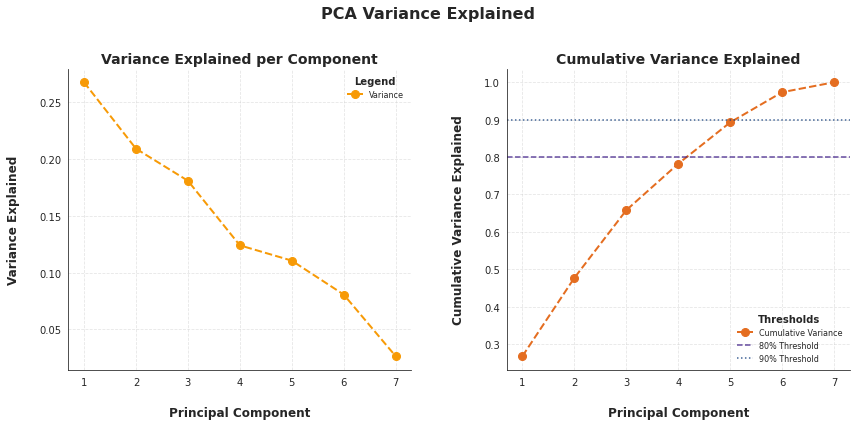

In [0]:
# Plotting the Explained Variance and Cumulative Explained Variance
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

# Plot 1: Variance Explained by Each Principal Component
ax1.plot(eigenvalues_df.index, eigenvalues_df['Variance'], marker='o', linestyle='--', 
         color=color_palette[0], linewidth=2, markersize=8, label='Variance')
ax1.set_xlabel("\nPrincipal Component", fontsize=12, weight='bold')
ax1.set_ylabel("Variance Explained\n", fontsize=12, weight='bold')
ax1.set_title("Variance Explained per Component", fontsize=14, weight='bold')
ax1.set_xticks(eigenvalues_df.index)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(loc='best', title='Legend', title_fontproperties={'weight': 'bold', 'size': 10}, 
           fontsize=8, frameon=False)

# Plot 2: Cumulative Variance Explained
ax2.plot(eigenvalues_df.index, eigenvalues_df['Cumulative Variance'], marker='o', linestyle='--', 
         color=color_palette[1], linewidth=2, markersize=8, label='Cumulative Variance')
ax2.set_xlabel("\nPrincipal Component", fontsize=12, weight='bold')
ax2.set_ylabel("\n\nCumulative Variance Explained\n", fontsize=12, weight='bold')
ax2.set_title("Cumulative Variance Explained", fontsize=14, weight='bold')
ax2.set_xticks(eigenvalues_df.index)
ax2.grid(True, linestyle='--', alpha=0.5)

# Add 80% and 90% threshold lines for Cumulative Variance
ax2.axhline(0.8, color=color_palette[6], linestyle='--', linewidth=1.5, alpha=0.8, label='80% Threshold')
ax2.axhline(0.9, color=color_palette[7], linestyle=':', linewidth=1.5, alpha=0.8, label='90% Threshold')
ax2.legend(loc='best', title='Thresholds', title_fontproperties={'weight': 'bold', 'size': 10}, 
           fontsize=8, frameon=False)

# Remove top and right spines for both plots
sns.despine(ax=ax1, top=True, right=True)
sns.despine(ax=ax2, top=True, right=True)

# Add centered suptitle
plt.suptitle("PCA Variance Explained\n", fontsize=16, weight='bold')
plt.show()

#### **How to choose the number of PCs?**

- **1st Rule of Thumb:** Keep \\( 80\\% \\) of the total variance \\( \rightarrow \\) **`n_components=4`** **[Variance Explained by each PC]**

- **2nd Rule of Thumb:** Keep the components with eigenvalues greater than 1 \\( \rightarrow \\) \\( PC \;var \ge 1 \\) \\( \rightarrow \\) In PySpark, `PCA` does not return the eigenvalues, and since **Eigenvalues** measure the variance explained by each component, we will consider same `n_components` as the first rule of thumb. \\( \rightarrow \\)**`n_components=4`**

- **3rd Rule of Thumb:** Keep the components based on the **Scree Plot** \\( \rightarrow \\) **`n_components = 4`** **[Scree Plot]**

> **Decision:** Although several rules of thumb (e.g., retaining \\( 80\\% \\) of the variance, keeping eigenvalues \\( ≥ 1,\\) or using the Scree Plot) suggest selecting **4 principal components**, we decided **not to apply PCA for dimensionality reduction**.
> 
> Since the dataset has only **7 original features**, reducing to \\( 4 \\) components would offer a **small gain in dimensionality reduction** at the cost of **losing the interpretability** of the original variables. Additionally, we are **not facing a high-dimensionality problem**, so the benefit of applying PCA is limited in this case.


In [0]:
# Re-run the PCA pipeline with 4 PCs
pca_final = PCA(k=4, inputCol="scaled_features", outputCol="pca_features")
pipeline_final = Pipeline(stages=[indexer, assembler, scaler, pca_final])
pca_model_final = pipeline_final.fit(clustering_df)
processed_df_final = pca_model_final.transform(clustering_df)
processed_df_final.select("Combined_Sentiment","Combined_Sentiment_index", "pca_features").limit(5).display()

Combined_Sentiment,Combined_Sentiment_index,pca_features
Positive,4.0,"Map(vectorType -> dense, length -> 4, values -> List(-1.0604182273300689, -0.6311372669501387, -0.9911416600387936, 1.0045031750047357))"
Positive Tendency,3.0,"Map(vectorType -> dense, length -> 4, values -> List(0.5214244806876297, -0.5084906290321447, -0.04346683892250314, -0.6964434481913031))"
Neutral,2.0,"Map(vectorType -> dense, length -> 4, values -> List(1.4800035852151214, 0.5137494396748915, -0.6759773162978968, -0.2591393388187249))"
Positive,4.0,"Map(vectorType -> dense, length -> 4, values -> List(-0.12739214810210084, -1.4999731689377662, -0.1323939019915903, 0.10816036092924934))"
Positive Tendency,3.0,"Map(vectorType -> dense, length -> 4, values -> List(0.5724233365691989, -1.9853312437606725, -0.015395113171955965, 1.6811804923153155))"


In [0]:
# Extract PCA features
pca_features_final = processed_df_final.select("parent_asin", "pca_features").toPandas()
pca_features_final = pca_features_final.rename(columns={"pca_features": "features"})
pca_features_final['features'] = pca_features_final['features'].apply(lambda x: np.array(x.toArray()))

In [0]:
# Convert to numpy array
X = np.array(pca_features_final['features'].tolist())

# Check the shape of the data
print("\n\033[1mShape of PCA Features:\033[0m ", X.shape)

# Check the first 5 rows of PCA features
print("\n\033[1mFirst 5 Rows of PCA Features:\033[0m \n", X[:5])


Shape of PCA Features:  (100476, 4)

First 5 Rows of PCA Features: 
 [[-1.06041823 -0.63113727 -0.99114166  1.00450318]
 [ 0.52142448 -0.50849063 -0.04346684 -0.69644345]
 [ 1.48000359  0.51374944 -0.67597732 -0.25913934]
 [-0.12739215 -1.49997317 -0.1323939   0.10816036]
 [ 0.57242334 -1.98533124 -0.01539511  1.68118049]]


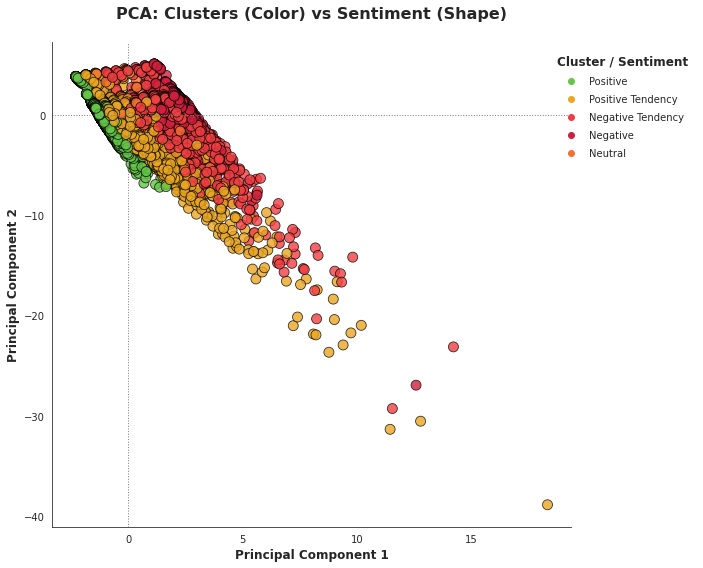

In [0]:
# Plot PCA results
processed_dfp_final = processed_df_final.toPandas()
processed_dfp_final["PC1"] = processed_dfp_final["pca_features"].apply(lambda x: x[0])
processed_dfp_final["PC2"] = processed_dfp_final["pca_features"].apply(lambda x: x[1])

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=processed_dfp_final, x="PC1", y="PC2", hue="Combined_Sentiment",
    palette=sentiment_colors_full, s=100, edgecolor="black", alpha=0.8)
plt.axhline(0, linestyle=':', color='gray', linewidth=1)
plt.axvline(0, linestyle=':', color='gray', linewidth=1)
plt.title("PCA: Clusters (Color) vs Sentiment (Shape)\n", fontsize=16, weight='bold')
plt.xlabel("Principal Component 1", fontsize=12, weight='bold')
plt.ylabel("Principal Component 2", fontsize=12, weight='bold')
plt.legend(title="Cluster / Sentiment", fontsize=10, loc='upper right', bbox_to_anchor=(1.25, 1),
           title_fontproperties={'weight':'bold', 'size':'12'}, labelspacing=0.8, borderpad=0.8, frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

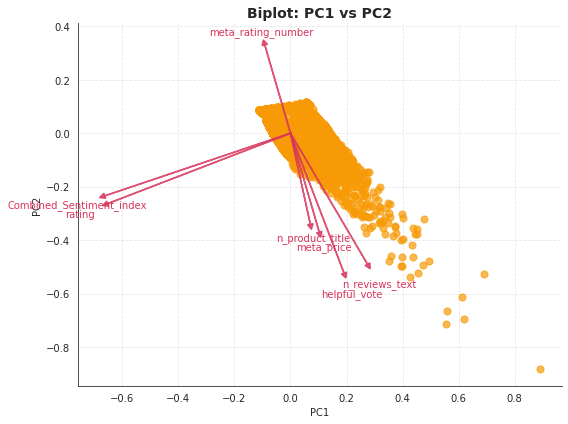

In [0]:
# Prepare PCA scores and loadings from the fitted Spark PCA model
coeff = pca_model.stages[-1].pc.toArray()                            # shape: [n_features, n_components]
score = np.vstack(processed_dfp_final["pca_features"].values)              # shape: [n_samples, n_components]
feature_labels = [
    "rating", "helpful_vote", "Combined_Sentiment_index", "n_reviews_text",
    "meta_price", "n_product_title", "meta_rating_number"
]

# Biplot for PC1 vs PC2
def biplot(score, coeff, labels=None):
    """Create a biplot of the PCA results.

    Args:
        score: PCA scores
        coeff: PCA loadings
        labels: Feature labels (optional)
    """
    xs, ys = score[:, 0], score[:, 1]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.figure(figsize=(8, 6))
    plt.scatter(xs * scalex, ys * scaley, c=color_palette[0], s=50, alpha=0.7)
    for i in range(coeff.shape[0]):
        plt.arrow(
            0, 0,
            coeff[i, 0], coeff[i, 1],
            color=color_palette[2], alpha=0.8,
            linewidth=1.5, head_width=0.02, head_length=0.02
        )
        lbl = labels[i] if labels else f"Var{i+1}"
        plt.text(
            coeff[i, 0] * 1.15, coeff[i, 1] * 1.15,
            lbl, color=color_palette[2], ha='center', va='center'
        )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot: PC1 vs PC2", fontsize=14, weight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    sns.despine(right=True, top=True)
    plt.tight_layout()
    plt.show()

# Grid of biplots and histograms for all PC pairs
def plot_all_biplots(score, coeff, labels=None, figsize=(20, 20)):
    """Create a grid of biplots and histograms for all pairs of principal components.
    Args:
        score: PCA scores
        coeff: PCA loadings
        labels: Feature labels (optional)
        figsize: Size of the figure
    """
    n = score.shape[1]
    fig, axes = plt.subplots(n, n, figsize=figsize, squeeze=False)
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i != j:
                ax.scatter(score[:, i], score[:, j], c=color_palette[0], s=30, alpha=0.5)
                for k in range(coeff.shape[0]):
                    ax.arrow(
                        0, 0,
                        coeff[k, i] * 2, coeff[k, j] * 2,
                        color=color_palette[2], alpha=0.8,
                        linewidth=1.2, head_width=0.02, head_length=0.02
                    )
                    if labels:
                        ax.text(
                            coeff[k, i] * 2.15, coeff[k, j] * 2.15,
                            labels[k], color=color_palette[2],
                            ha='center', va='center'
                        )
                ax.set_xlabel(f"PC{i+1}")
                ax.set_ylabel(f"PC{j+1}")
            else:
                ax.hist(score[:, i], bins=30, color=color_palette[1], alpha=0.4)
                ax.set_xlabel(f"PC{i+1}")
                ax.set_ylabel("Frequency")
            ax.grid(True, linestyle='--', alpha=0.5)
            sns.despine(ax=ax, right=True, top=True)
    plt.tight_layout()
    plt.show()

# Plot the biplots
biplot(score, coeff, labels=feature_labels)

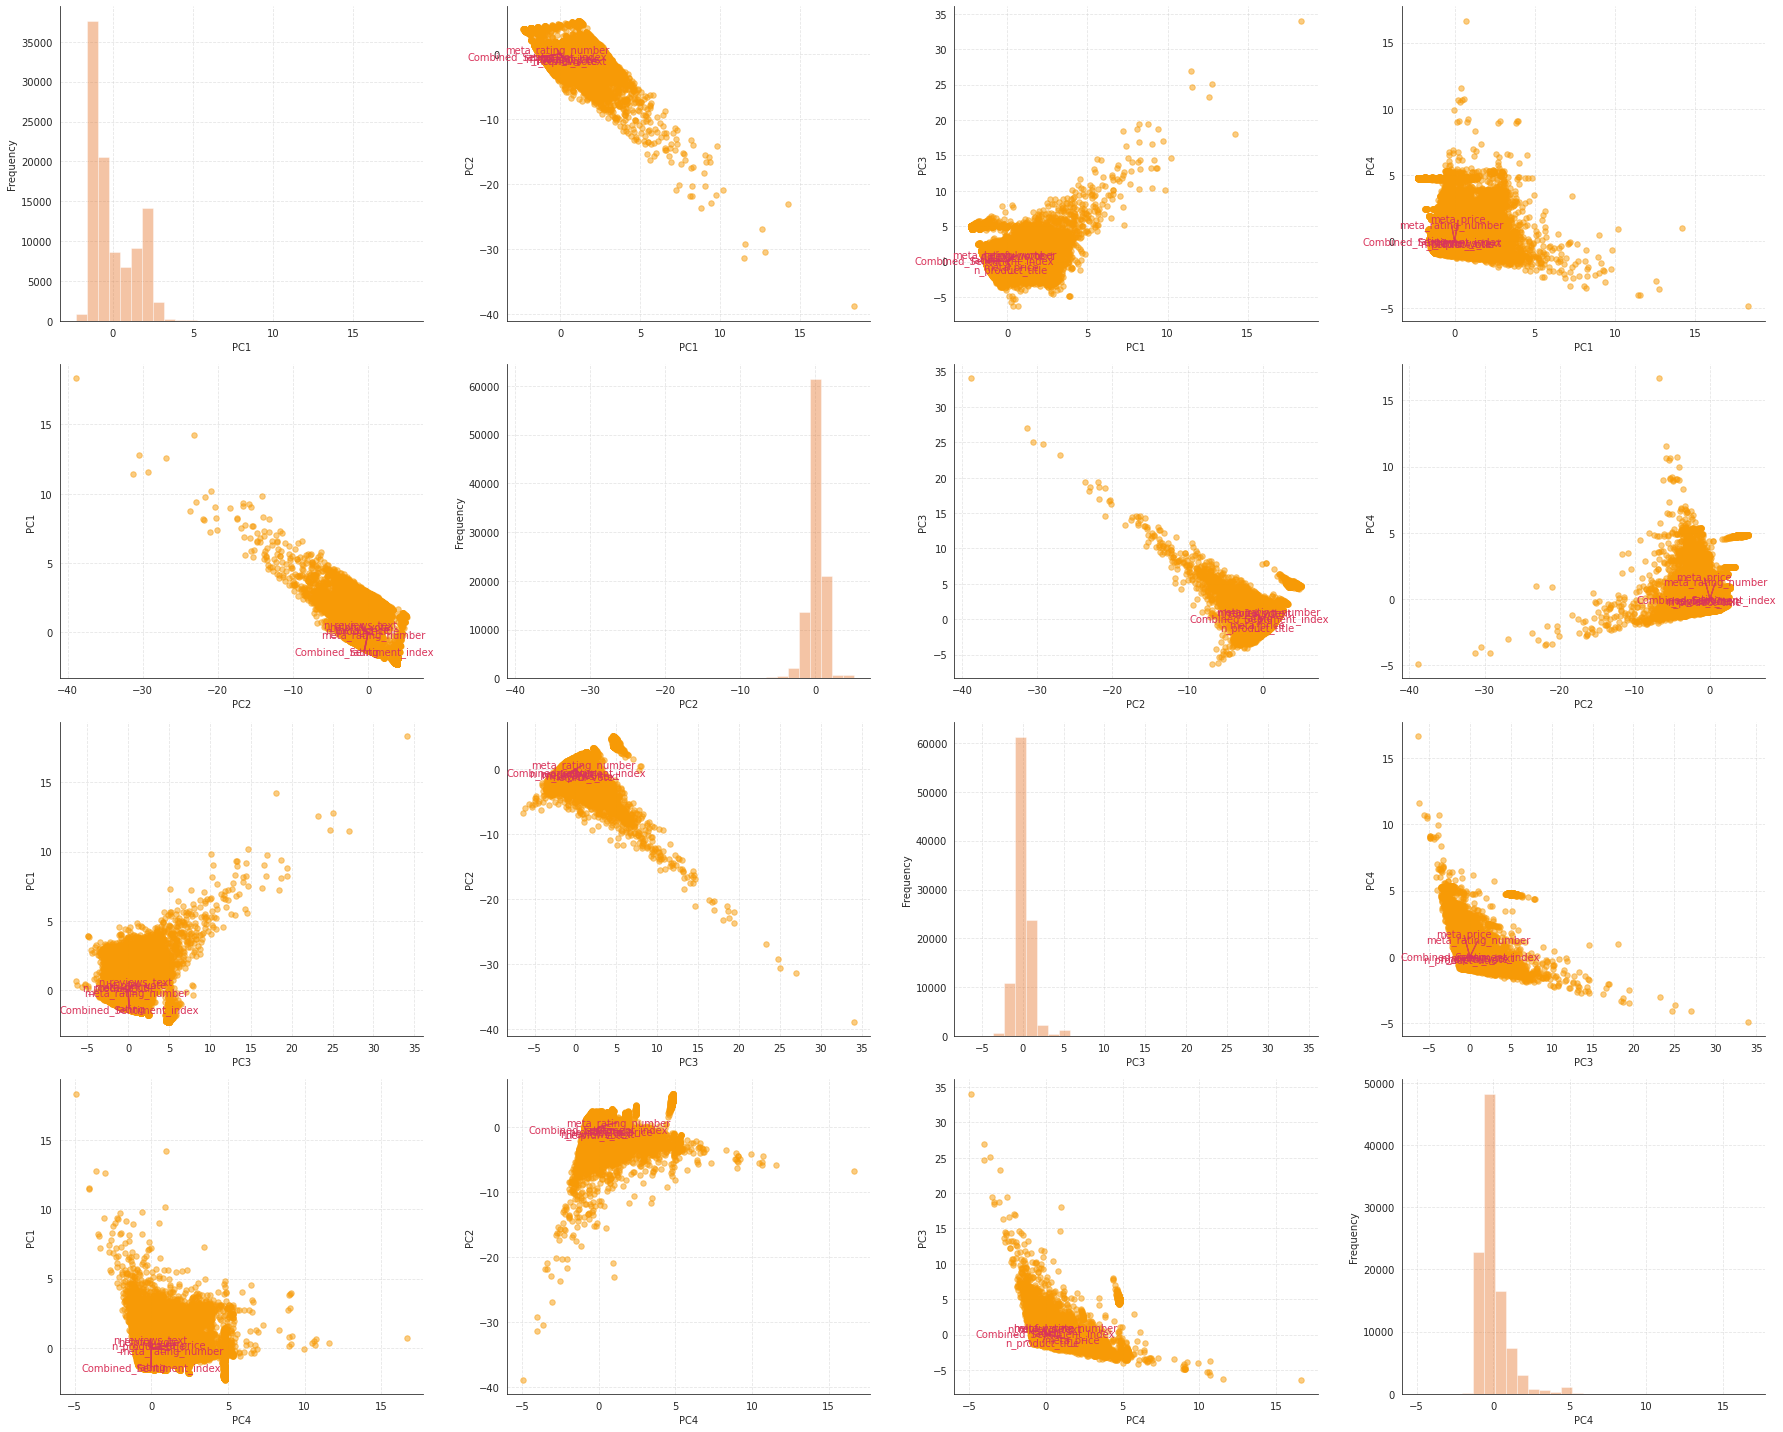

In [0]:
plot_all_biplots(score, coeff, labels=feature_labels, figsize=(25, 20))

> **Conclusion:** We will retain the **standardized original features** for the clustering step to preserve interpretability and avoid unnecessary transformation.

---

In [0]:
displayHTML('''
## <span style="color: #ffffff;">Clustering (K-Means)</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #d9345b;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #d9345b;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Clustering (K-Means)</b></h2></center>
</div>
''')

## Clustering (K-Means) 
 


 
 Clustering (K-Means)

## ⚙️ **Feature Scaling Pipeline**

Before applying K-Means clustering, it's crucial to scale the features. K-Means is sensitive to the scale of data because it uses Euclidean distance. Features with larger value ranges can disproportionately influence the clustering outcome. Here, we define a pipeline that includes:
1.  **`VectorIndexer`**: To handle categorical features if any were to be included directly (though for K-Means with numerical features, this might be less critical if all inputs to assembler are already numerical).
2.  **`VectorAssembler`**: To combine multiple feature columns into a single vector column.
3.  **`StandardScaler`**: To scale the assembled features to have zero mean and unit variance.

The `clustering_df` (assumed to be pre-processed and containing the relevant features) is transformed using this pipeline to produce `scaled_df`, which will be used for clustering.

In [0]:
# Since we will continue with original features, we will re-do the pipeline without PCA
scaled_model = Pipeline(stages=[indexer, assembler, scaler]).fit(clustering_df)
scaled_df = scaled_model.transform(clustering_df)
scaled_df.limit(5).display()

parent_asin,review_id,review_text,rating,helpful_vote,year,month,day,day_of_week,hour,TXRBSF_SentimentLabel,TXRBSF_SentimentScore,mDeBERTa_SentimentLabel,mDeBERTa_SentimentScore,Combined_Sentiment,n_reviews_text,product_title,meta_average_rating,meta_rating_number,meta_price,meta_store,TopicLabel,TopicScore,n_product_title,price_category,Combined_Sentiment_Mapped,Combined_Sentiment_index,features,scaled_features
B0BTTZFKYF,262103,Super computadora a un excelente precio Super computadora a un excelente precio,5,0,2022,4,29,6,1,Positive,0.9269018173217773,Positive,0.8928577899932861,Positive,10,Lenovo Legion 5 Gaming Laptop AMD Ryzen 7 5800H 16GB RAM 512GB Storage NVIDIA GeForce RTX 3050Ti 156 FHD Display Windows 11 Home Phantom Blue,4.6,619,1199.0,Lenovo,Laptops,0.56192547082901,25,500+,E_Positive,4.0,"Map(vectorType -> dense, length -> 7, values -> List(5.0, 0.0, 4.0, 10.0, 1199.0, 25.0, 619.0))","Map(vectorType -> dense, length -> 7, values -> List(0.7109557521195106, -0.3188199195802526, 0.8586380572593898, -0.5425666876792268, 1.4134143422083654, 0.22405385137661432, -0.23170571388630426))"
B0856QVM2F,846730,The chromebook duet is ok device best to buy a laptop or another 2 in 1 tablet I had the chromebook duet for three years now I had say some good things and bad things about this device first good thing about Chromebook duet you do the basic with things like school work or watch videos on YouTube Second you can use this as tablet play some Android games download apps and touch screen work really well Now cons with chromebook duet battery life isnt that good last life 2 or 3 hours of use Keyboard for Chromebook duet stop working for me I contact Lenovo their customer service didnt help me at all now buy Bluetooth keyboard since there were no help Some Android app will not work chromebook or take too long load basicically had sign out sign in back just for apps started work again,3,1,2023,2,2,5,12,Neutral,0.9579783082008362,Positive,0.7252811789512634,Positive Tendency,90,Lenovo Chromebook Duet 2in1 101 WUXGA 1920 x 1200 Display MediaTek Helio P60T 4GB LPDDR4X RAM 64GB eMCP SSD Integrated ARM G72 MP3 Graphics Chrome OS ZA6F0031US Ice Blue Iron Grey,4.4,1306,334.65,Lenovo,Drives and Storage,0.41558924317359924,30,250 - 500,D_PositiveTendency,3.0,"Map(vectorType -> dense, length -> 7, values -> List(3.0, 1.0, 3.0, 90.0, 334.65, 30.0, 1306.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.5673104650995225, -0.12732670899379192, 0.20376351410061194, 1.0523150128842538, -0.5907436944983296, 0.9650980917981163, -0.15452015502676947))"
B08V1WK4LB,933085,Guess Im going to Nvidia First I was lucky enough to get one of the bad 7900XTXs from AMD now I buy this and the fans wont spin at all Run a bench test and it goes over 110 Celsius System crash and all Im done Nvidia here I come,1,1,2023,3,11,7,5,Neutral,0.9253247976303101,Neutral,0.40723565220832825,Neutral,28,PowerColor Red Dragon AMD Radeon RX 6800 XT Gaming Graphics Card with 16GB GDDR6 Memory Powered by AMD RDNA 2 Raytracing PCI Express 40 HDMI 21 AMD Infinity Cache,4.5,222,549.99,PowerColor,PC Gaming,0.5035871863365173,27,500+,C_Neutral,2.0,"Map(vectorType -> dense, length -> 7, values -> List(1.0, 1.0, 2.0, 28.0, 549.99, 27.0, 222.0))","Map(vectorType -> dense, length -> 7, values -> List(-1.8455766823185555, -0.12732670899379192, -0.45111102905816597, -0.1837183050524437, -0.09143740465692306, 0.5204715475452151, -0.27630930466830617))"
B0C8J5C5CH,414300,Pretty good overall I have been building and buying computers for years I mainly used desktops because of the work I do mostly engineering programs and it was much cheaper for me to build a powerful desktop with the graphics I needed then buy a laptop I bought my wife a Asus laptop for her birthday 8 years ago I7 with touch screen I was impressed and bought a few more a year or two later for our CNC programmers to use on the floor My wife still uses hers and it still performs pretty damn good So l bought this o

### **Number of Clusters - Elbow Method (Inertia)**

The Elbow Method is a heuristic used to determine the optimal number of clusters in a dataset. It involves plotting the explained variation (inertia, or Within-Cluster Sum of Squares - WCSS) as a function of the number of clusters. The "elbow" point on the plot, where the rate of decrease in inertia sharply changes, suggests a suitable number of clusters. Adding more clusters beyond this point yields diminishing returns in terms of explained variance.

#### **Inertia Formula:**

$$\sum_{j=0}^{C}\sum_{i=0}^{n_j}(||x_i - \mu_j||^2)$$
, where:

- \\( C \\): Set of identified clusters.
- \\( n_j \\): Set of observations belonging to cluster \\( j \\).
- \\( x_i \\): Observation \\( i \\).
- \\( \mu_j \\): Centroid of cluster \\( j \\).

### **Number of Clusters - Silhouette Plot**

#### **Silhouette Coefficient**

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- \\( a \\): The mean distance between a sample and all other points in the same cluster.
- \\( b \\): The mean distance between a sample and all other points in the next nearest cluster

---


If \\( b > a \\), then what?

Then the sample is closer to the points in the cluster it is assigned to (compared to the points in the next nearest cluster)

$$s \text{ is positive }$$


---


If \\( b = a \\), then what?

Then the sample is equally distant to the points in the cluster it is assigned to as well as the points in the next closest cluster

$$s \text{ is 0}$$



---

If \\(b < a \\), then what?

Then the sample is closer to the points in the next closest cluster (compared to the points in the same cluster).

$$s \text{ is negative }$$


---

**If the average value of \\( s \\) is high, then what?**


"Silhouette coefficients (as these values are referred to as) near \\( +1 \\) indicate that the sample is far away from the neighboring clusters. A value of \\( 0 \\) indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster."

- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html



In [0]:
%scala
//This allows easy embedding of publicly available information into any other notebook
//Example usage:
// Source: https://lamastex.github.io/scalable-data-science/sds/2/2/db/018_LinRegIntro.html
// displayHTML(frameIt("https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation#Topics_in_LDA",250))
def frameIt( u:String, h:Int ) : String = {
      """<iframe 
 src=""""+ u+""""
 width="95%" height="""" + h + """"
 sandbox>
  <p>
    <a href="http://spark.apache.org/docs/latest/index.html">
      Fallback link for browsers that, unlikely, don't support frames
    </a>
  </p>
</iframe>"""
   }
displayHTML(frameIt("https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html",500))

Fallback link for browsers that, unlikely, don't support frames

> We will iterate through a range of cluster numbers (\\(2\\) to \\(10\\)) and plot their corresponding inertia values.

K-Means:   0%|          | 0/9 [00:00<?, ?K/s]


For n_clusters = 2, the average silhouette_score is : 0.47895547771709507



K-Means:  11%|█         | 1/9 [02:30<20:00, 150.12s/K]


For n_clusters = 3, the average silhouette_score is : 0.3347280955505284



K-Means:  22%|██▏       | 2/9 [04:47<16:39, 142.82s/K]


For n_clusters = 4, the average silhouette_score is : 0.39476086906916324



K-Means:  33%|███▎      | 3/9 [07:02<13:54, 139.16s/K]


For n_clusters = 5, the average silhouette_score is : 0.3976905384794208



K-Means:  44%|████▍     | 4/9 [09:14<11:20, 136.10s/K]


For n_clusters = 6, the average silhouette_score is : 0.5258469891862086



K-Means:  56%|█████▌    | 5/9 [11:28<09:02, 135.64s/K]


For n_clusters = 7, the average silhouette_score is : 0.4435897288605422



K-Means:  67%|██████▋   | 6/9 [13:40<06:42, 134.24s/K]


For n_clusters = 8, the average silhouette_score is : 0.44417800981945343



K-Means:  78%|███████▊  | 7/9 [15:49<04:25, 132.52s/K]


For n_clusters = 9, the average silhouette_score is : 0.4552466319290992



K-Means:  89%|████████▉ | 8/9 [17:59<02:11, 131.67s/K]


For n_clusters = 10, the average silhouette_score is : 0.4034451489121098



K-Means: 100%|██████████| 9/9 [20:08<00:00, 131.05s/K]

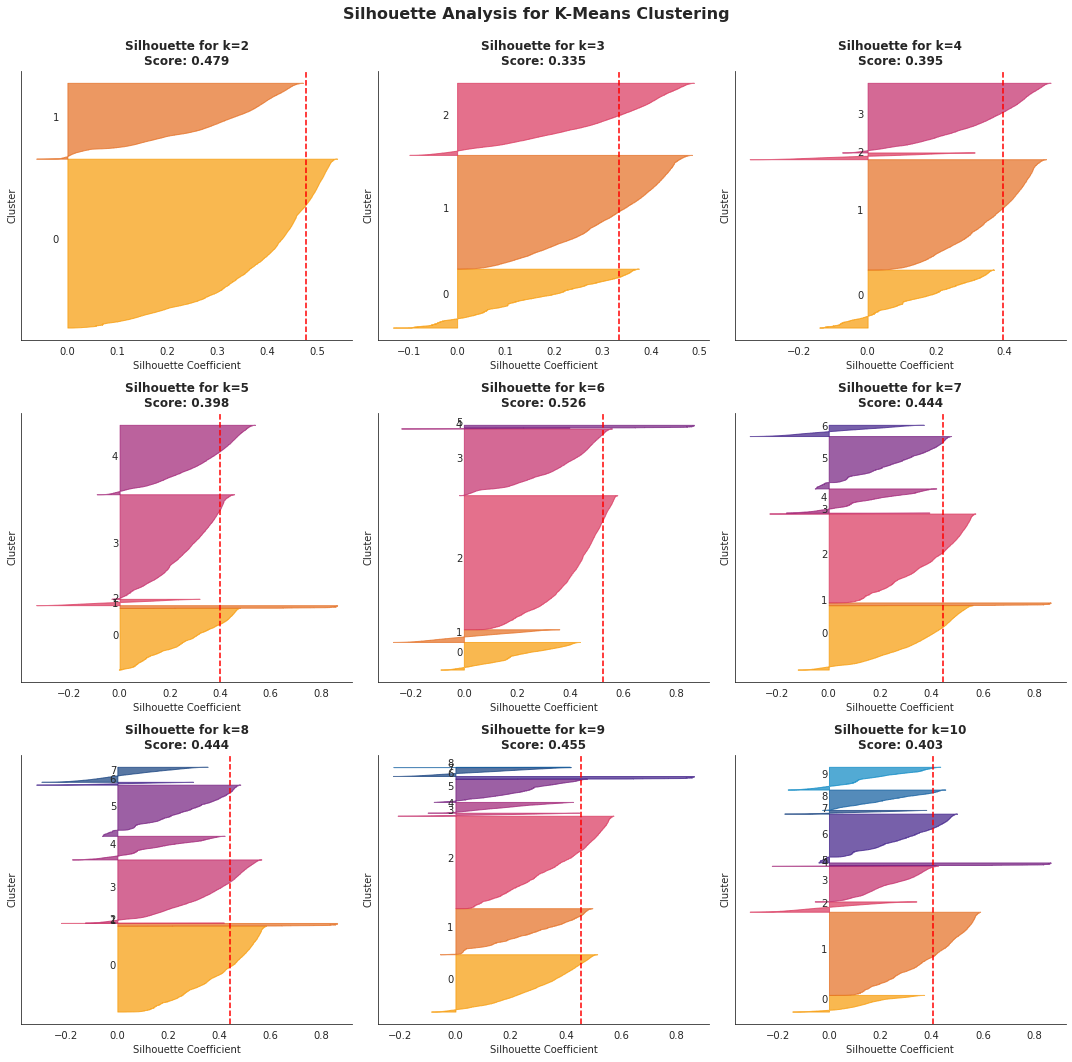


Time of Execution (K-Means): 1211.3639047145844 seconds (0:20:11.363905 h)



In [0]:
# Start the timer
start_time = time.time()

# Define range of clusters to test
range_clusters = range(2, 11)                 # 2 to 10 clusters (inclusive)
inertia = []
silhouette_avg_scores = []

# Plot Silhouette Analysis
num_columns = 3
n_plots = len(range_clusters)
n_rows = ceil(n_plots / num_columns)
fig, axes = plt.subplots(n_rows, num_columns, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# List to store silhouette scores
silhouette_avg_scores = []

# Initialize progress bar with total rows
total_k_to_test = n_plots
pbar = tqdm(total=total_k_to_test, desc="K-Means", unit="K")

# Run K-Means for each number of clusters and plot silhouette analysis
for idx, k in enumerate(range_clusters):

    # Fit KMeans model
    kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=k, seed=2025)
    kmeans_model = kmeans.fit(scaled_df)
    
    # Transform data to get cluster assignments
    clustered_df = kmeans_model.transform(scaled_df)

    # Compute inertia (sum of squared distances to cluster centers)
    # Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.ClusteringEvaluator.html
    evaluator = ClusteringEvaluator(
        predictionCol="cluster", featuresCol="scaled_features", 
        metricName="silhouette", distanceMeasure="squaredEuclidean"
    )
    inertia.append(kmeans_model.summary.trainingCost)

    # Compute avg silhouette score
    silhouette_avg = evaluator.evaluate(clustered_df)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"\n\033[1mFor n_clusters = {k}, the average silhouette_score is :\033[0m {silhouette_avg}\n")
    
    # Convert to Pandas for silhouette calculation
    pdf = clustered_df.select("scaled_features", "cluster").toPandas()
    X = np.array([x.toArray() for x in pdf["scaled_features"]])
    labels = pdf["cluster"].astype(int)
    
    # Calculate silhouette scores for each sample
    silhouette_vals = silhouette_samples(X, labels)
    
    # Plot silhouette analysis    
    ax = axes[idx]
    y_lower = 10
    for i in range(k):
        ith_cluster_vals = silhouette_vals[labels == i]
        ith_cluster_vals.sort()
        size_cluster_i = ith_cluster_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        color = color_palette[i % len(color_palette)]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_vals, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), fontsize=10)
        y_lower = y_upper + 10
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(f"Silhouette for k={k}\nScore: {silhouette_avg:.3f}", fontsize=12, weight='bold')
    ax.set_xlabel("Silhouette Coefficient", fontsize=10)
    ax.set_ylabel("Cluster", fontsize=10)
    ax.set_yticks([])
    sns.despine(ax=ax, top=True, right=True)

    # Update progress bar
    pbar.update(1)

# Hide unused subplots
for i in range(n_plots, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Silhouette Analysis for K-Means Clustering\n", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (K-Means):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)\n")

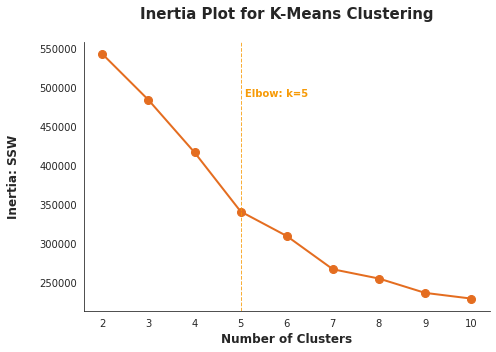

In [0]:
# Plot Inertia vs Number of Clusters
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(range_clusters, inertia, marker='o', color=color_palette[1], linewidth=2, markersize=8)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSW\n", size=12, weight='bold')
ax.set_xlabel("Number of Clusters", size=12, weight='bold')
ax.set_title("Inertia Plot for K-Means Clustering\n", size=15, weight='bold')

# Highlight elbow point (k chosen)
ax.axvline(x=5, color=color_palette[0], linestyle='--', linewidth=1, alpha=0.8)
ax.text(5.1, max(inertia)*0.9, "Elbow: k=5", fontsize=10, color=color_palette[0], weight='bold')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

**Insight from Elbow Method and Silhouette Analysis:**
The inertia plot typically shows an "elbow" where adding more clusters provides diminishing returns. The silhouette plots help visualize the quality of clustering for each \\(k\\). A common approach is to look for a \\(k\\) that has a relatively high average silhouette score and where all clusters have silhouette scores above the average, indicating well-separated and cohesive clusters.

Based on the provided silhouette plots, \\(k=6\\) shows a notably high average silhouette score (\\(0.526\\)). However, considering the subsequent analysis focusing on 3 clusters for interpretability and alignment with business understanding, we will proceed with a final model of \\(k=3\\). The choice of \\(k=3\\) is driven by the need for actionable and distinct customer segments, even if a higher \\(k\\) might yield a better mathematical score in some metrics. We also explore \\(k=5\\) as initially suggested by the elbow plot in the code.

#### **k=5**

In [0]:
# Start the timer for KMeans
start_time = time.time()

# Use standardized original features as input for clustering
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=5, seed=2025)

# Fit model
kmeans_final_model = kmeans.fit(processed_df)

# Make predictions
clustered_df = kmeans_final_model.transform(processed_df)

# Show 5 samples of cluster assignments with original labels
clustered_df.select("cluster", "Combined_Sentiment_index", "scaled_features").limit(5).display()

# Tranform to Pandas to visualization
clustered_dfp = clustered_df.toPandas()

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (K-Means Final Model):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)\n")

cluster,Combined_Sentiment_index,scaled_features
3,4.0,"Map(vectorType -> dense, length -> 7, values -> List(0.7109557521195106, -0.3188199195802526, 0.8586380572593898, -0.5425666876792268, 1.4134143422083654, 0.22405385137661432, -0.23170571388630426))"
3,3.0,"Map(vectorType -> dense, length -> 7, values -> List(-0.5673104650995225, -0.12732670899379192, 0.20376351410061194, 1.0523150128842538, -0.5907436944983296, 0.9650980917981163, -0.15452015502676947))"
4,2.0,"Map(vectorType -> dense, length -> 7, values -> List(-1.8455766823185555, -0.12732670899379192, -0.45111102905816597, -0.1837183050524437, -0.09143740465692306, 0.5204715475452151, -0.27630930466830617))"
3,4.0,"Map(vectorType -> dense, length -> 7, values -> List(0.07182264350999404, 0.44715292276559004, 0.8586380572593898, 0.9526349065990362, 0.5577720691644543, 0.8168892437138159, -0.28664565316186835))"
3,3.0,"Map(vectorType -> dense, length -> 7, values -> List(0.07182264350999404, 0.6386461333520507, 0.20376351410061194, 1.3513553317399063, 2.4428886601552686, -0.2205726928762869, -0.28372451119629644))"



Time of Execution (K-Means Final Model): 22.100579023361206 seconds (0:00:22.100579 h)



In [0]:
# Convert to Pandas
pdf = clustered_df.toPandas()

# Absolute and Relative Frequencies of Clusters
abs_freq_df = pd.DataFrame({
    'n': pdf['cluster'].value_counts().sort_index(),
    '%': round((pdf['cluster'].value_counts(normalize=True).sort_index() * 100), 2)
}).reset_index()
abs_freq_df.set_index('index', inplace=True)
abs_freq_df.index.name = 'Cluster'
abs_freq_df

,n,%
Cluster,,
0,25305,25.19
1,1134,1.13
2,2583,2.57
3,42955,42.75
4,28499,28.36


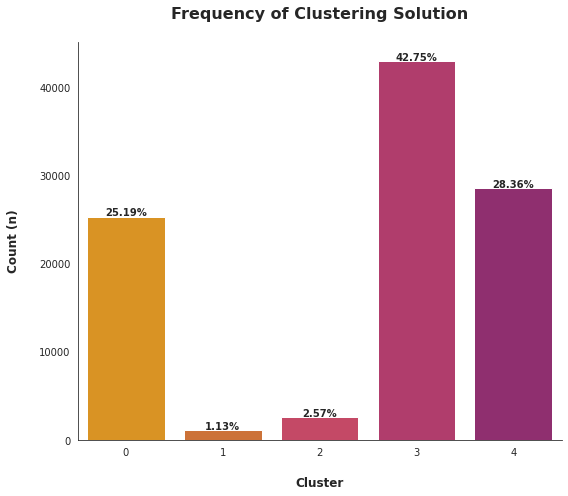

In [0]:
# Barplot with Frequencies of Clusters
cluster_counts = pdf["cluster"].value_counts().sort_index()
cluster_freq = pdf["cluster"].value_counts(normalize=True).sort_index() * 100
cluster_freq_df = pd.DataFrame({"n": cluster_counts, "%": cluster_freq})

fig = plt.figure(figsize=(8, 7))
sns.barplot(data=cluster_freq_df.reset_index(), x='index', y="n", palette=color_palette)
for i in range(cluster_freq_df.shape[0]):
    plt.text(i, cluster_freq_df["n"][i] + 100, f"{cluster_freq_df['%'][i]:.2f}%", ha='center', fontsize=10, fontweight='bold')
plt.xlabel("\nCluster", fontsize=12, weight='bold')
plt.ylabel("Count (n)\n", fontsize=12, weight='bold')
plt.title("Frequency of Clustering Solution\n", fontsize=16, weight='bold')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

---

#### **🚀 Final K-Means Model (k=3)**

After evaluating various numbers of clusters, we select \\(k=3\\) for our final K-Means model. This choice aligns with the goal of creating distinct and interpretable customer segments as outlined in our project's clustering analysis (Mainstream Mentions, Premium Perspectives, and Critical Reviews). While other $k$ values might offer slightly better silhouette scores, \\(k=3\\) provides a balance between statistical separation and business applicability.

The model is trained on the scaled features, and predictions (cluster assignments) are made.

In [0]:
# Start the timer for KMeans
start_time = time.time()

# Use standardized original features as input for clustering
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=3, seed=2025)

# Fit model
kmeans_final_model = kmeans.fit(processed_df)

# Make predictions
clustered_df = kmeans_final_model.transform(processed_df)

# Show 5 samples of cluster assignments with original labels
clustered_df.select("cluster", "Combined_Sentiment_index", "scaled_features").limit(5).display()

# Tranform to Pandas to visualization
clustered_dfp = clustered_df.toPandas()

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (K-Means Final Model):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)\n")

cluster,Combined_Sentiment_index,scaled_features
1,4.0,"Map(vectorType -> dense, length -> 7, values -> List(0.7109557521195106, -0.3188199195802526, 0.8586380572593898, -0.5425666876792268, 1.4134143422083654, 0.22405385137661432, -0.23170571388630426))"
1,3.0,"Map(vectorType -> dense, length -> 7, values -> List(-0.5673104650995225, -0.12732670899379192, 0.20376351410061194, 1.0523150128842538, -0.5907436944983296, 0.9650980917981163, -0.15452015502676947))"
2,2.0,"Map(vectorType -> dense, length -> 7, values -> List(-1.8455766823185555, -0.12732670899379192, -0.45111102905816597, -0.1837183050524437, -0.09143740465692306, 0.5204715475452151, -0.27630930466830617))"
1,4.0,"Map(vectorType -> dense, length -> 7, values -> List(0.07182264350999404, 0.44715292276559004, 0.8586380572593898, 0.9526349065990362, 0.5577720691644543, 0.8168892437138159, -0.28664565316186835))"
1,3.0,"Map(vectorType -> dense, length -> 7, values -> List(0.07182264350999404, 0.6386461333520507, 0.20376351410061194, 1.3513553317399063, 2.4428886601552686, -0.2205726928762869, -0.28372451119629644))"



Time of Execution (K-Means Final Model): 20.14436364173889 seconds (0:00:20.144364 h)



In [0]:
# Convert to Pandas
pdf = clustered_df.toPandas()

# Absolute and Relative Frequencies of Clusters
abs_freq_df = pd.DataFrame({
    'n': pdf['cluster'].value_counts().sort_index(),
    '%': round((pdf['cluster'].value_counts(normalize=True).sort_index() * 100), 2)
}).reset_index()
abs_freq_df.set_index('index', inplace=True)
abs_freq_df.index.name = 'Cluster'
abs_freq_df

,n,%
Cluster,,
0,24173,24.06
1,46711,46.49
2,29592,29.45


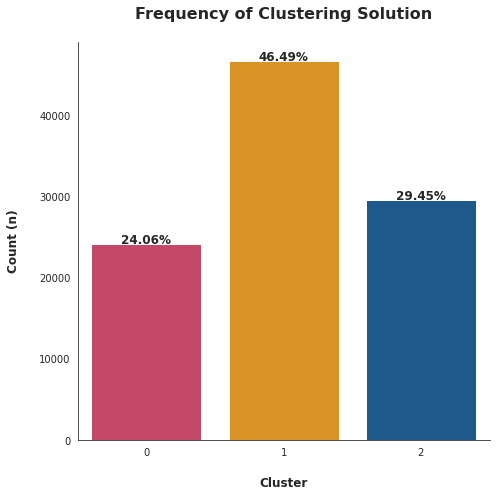

In [0]:
# Frequencies of Clusters
cluster_counts = pdf["cluster"].value_counts().sort_index()
cluster_freq = pdf["cluster"].value_counts(normalize=True).sort_index() * 100
cluster_freq_df = pd.DataFrame({"n": cluster_counts, "%": cluster_freq})

# Define different colours for clusters
cluster_color ={0: color_palette[2], 
                1: color_palette[0], 
                2: color_palette[8]
}

# Barplot with Frequencies of Clusters
fig = plt.figure(figsize=(7, 7))
sns.barplot(data=cluster_freq_df.reset_index(), x='index', y="n", palette=cluster_color)
for i in range(cluster_freq_df.shape[0]):
    plt.text(i, cluster_freq_df["n"][i] + 100, f"{cluster_freq_df['%'][i]:.2f}%", ha='center', fontsize=12, fontweight='bold')
plt.xlabel("\nCluster", fontsize=12, weight='bold')
plt.ylabel("Count (n)\n", fontsize=12, weight='bold')
plt.title("Frequency of Clustering Solution\n", fontsize=16, weight='bold')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

### **📈 Cluster Distribution (k=3)**

The bar plot below shows the absolute and relative frequencies of reviews assigned to each of the 3 clusters. This gives an overview of the size of each identified customer segment.

-   **Cluster 0 (Mainstream Mentions)**: Represents 24.06% of the reviews.
-   **Cluster 1 (Premium Perspectives)**: The largest segment, accounting for 46.49% of reviews.
-   **Cluster 2 (Critical Reviews)**: Comprises 29.45% of the reviews.

These proportions indicate a significant portion of reviews fall into the "Premium Perspectives" and "Critical Reviews" categories, with a smaller but substantial "Mainstream Mentions" group.

---

### **Cluster Profiling Heatmap**

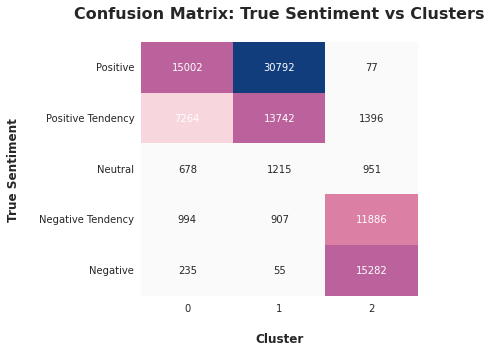

In [0]:
# Create a confusion matrix (Clusters vs Sentiment)
confusion_matrix_df = pd.crosstab(pdf["Combined_Sentiment"], pdf["cluster"], rownames=["True Sentiment"], colnames=["Cluster"])

# Define the desired order for sentiment categories
sentiment_order = ['Positive', 'Positive Tendency', 'Neutral', 'Negative Tendency', 'Negative']

# Reindex the confusion matrix to match the desired order
confusion_matrix_df = confusion_matrix_df.reindex(index=sentiment_order, columns=range(3), fill_value=0)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap=cmap_t, cbar=False)
plt.title("Confusion Matrix: True Sentiment vs Clusters\n", fontsize=16, weight='bold')
plt.xlabel("\nCluster", fontsize=12, weight='bold')
plt.ylabel("True Sentiment\n", fontsize=12, weight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **🔍 Cluster Profiling Heatmap & Sentiment Analysis (k=3)**

To understand the characteristics of each cluster, we'll examine their relationship with review sentiment and other key features.

#### **Confusion Matrix: True Sentiment vs Clusters**
The confusion matrix cross-tabulates the true sentiment labels (Positive, Positive Tendency, Neutral, Negative Tendency, Negative) against the assigned cluster labels (0, 1, 2). This helps visualize how sentiments are distributed across the clusters.

-   **Cluster 0 (Mainstream Mentions)** and **Cluster 1 (Premium Perspectives)** predominantly contain 'Positive' and 'Positive Tendency' reviews.
-   **Cluster 2 (Critical Reviews)** is heavily skewed towards 'Negative Tendency' and 'Negative' reviews, confirming its nature.

In [0]:
# Compute mean feature values per cluster (Original Values)
value_vars = ['rating', 'helpful_vote', 'n_reviews_text', 'meta_price', 'n_product_title', 'meta_rating_number', 'Combined_Sentiment_index']
cluster_means = clustered_df.groupBy("cluster").agg(
    *[F.mean(col).alias(col) for col in value_vars]
).toPandas().set_index("cluster").T
cluster_means = cluster_means[[0, 1, 2]]
cluster_means

cluster,0,1,2
rating,4.758119,4.798506,1.738713
helpful_vote,1.245067,1.643082,2.042343
n_reviews_text,29.271253,35.039669,47.139159
meta_price,440.594457,656.416156,605.255435
n_product_title,15.437141,27.401854,23.887402
meta_rating_number,6891.566458,1004.750016,1888.559408
Combined_Sentiment_index,3.481157,3.590824,0.617870


#### **Cluster Profiling Heatmap: Mean Feature Values**
The heatmap visualizes the mean values of scaled features for each cluster. This allows for a direct comparison of how clusters differ across various dimensions like rating, price, review length, etc. Darker shades of blue indicate higher-than-average values for that feature within the cluster, while red indicates lower-than-average values.

From the heatmap and corresponding mean values (original values shown below for context):
-   **Cluster 0 (Mainstream Mentions)**:
    -   Average `rating`: 4.76 (High)
    -   `meta_price`: Relatively lower (Mean $440, reflects lower-priced products)
    -   `n_reviews_text`: Shorter reviews (Mean 29.3)
    -   `meta_rating_number`: Significantly higher (Mean 6891, products with many reviews)
    -   `Combined_Sentiment_index`: High (Mean 3.48, positive)
-   **Cluster 1 (Premium Perspectives)**:
    -   Average `rating`: 4.80 (Highest)
    -   `meta_price`: Higher (Mean $656, premium products)
    -   `n_reviews_text`: Moderate review length (Mean 35.0)
    -   `meta_rating_number`: Lower (Mean 1004, products with fewer, but good, ratings)
    -   `Combined_Sentiment_index`: Highest (Mean 3.59, very positive)
-   **Cluster 2 (Critical Reviews)**:
    -   Average `rating`: 1.74 (Very Low)
    -   `meta_price`: Moderate (Mean $605)
    -   `n_reviews_text`: Longer reviews (Mean 47.1, detailed negative feedback)
    -   `helpful_vote`: Slightly higher (Mean 2.04)
    -   `Combined_Sentiment_index`: Very Low (Mean 0.62, negative)

These profiles align well with the descriptions in "Appendix E": "Mainstream Mentions" for affordable, highly-reviewed items; "Premium Perspectives" for high-priced items with good, though fewer, ratings; and "Critical Reviews" for products receiving negative feedback.

### **Cluster Analysis**

In [0]:
# Columns of the clustered DataFrame
clustered_dfp.columns

Out[46]: Index(['parent_asin', 'review_id', 'review_text', 'rating', 'helpful_vote',
       'year', 'month', 'day', 'day_of_week', 'hour', 'TXRBSF_SentimentLabel',
       'TXRBSF_SentimentScore', 'mDeBERTa_SentimentLabel',
       'mDeBERTa_SentimentScore', 'Combined_Sentiment', 'n_reviews_text',
       'product_title', 'meta_average_rating', 'meta_rating_number',
       'meta_price', 'meta_store', 'TopicLabel', 'TopicScore',
       'n_product_title', 'price_category', 'Combined_Sentiment_Mapped',
       'Combined_Sentiment_index', 'features', 'scaled_features',
       'pca_features', 'cluster'],
      dtype='object')

In [0]:
# List of clusters labels
clusters = sorted(list(clustered_dfp['cluster'].unique()))
clusters

Out[47]: [0, 1, 2]

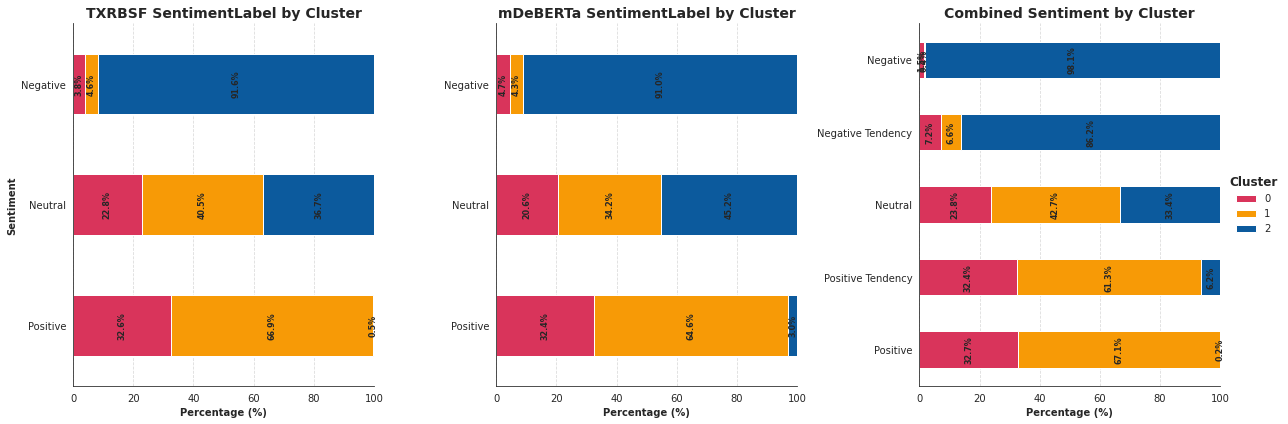

In [0]:
# ============================================
#      Sentiment Labels by Cluster
# ============================================
# Define sentiment labels for each variable
sentiment_labels_dict = {
    'TXRBSF_SentimentLabel': ['Positive', 'Neutral', 'Negative'],
    'mDeBERTa_SentimentLabel': ['Positive', 'Neutral', 'Negative'],
    'Combined_Sentiment': ['Positive', 'Positive Tendency', 'Neutral', 'Negative Tendency', 'Negative']
}

# Aggregate counts for sentiment variables by cluster
sentiment_vars = ['TXRBSF_SentimentLabel', 'mDeBERTa_SentimentLabel', 'Combined_Sentiment']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, var in enumerate(sentiment_vars):
    # Get the appropriate sentiment labels for this variable
    sentiment_labels = sentiment_labels_dict[var]
    
    # Group by cluster and sentiment variable, count, and convert to Pandas
    df_counts = (clustered_df.groupBy("cluster", var)
                 .count()
                 .orderBy("cluster", F.desc("count"))
                 .toPandas())
    
    # Pivot to get counts per cluster and sentiment category
    df_pivot = df_counts.pivot(index=var, columns='cluster', values='count').fillna(0)
    
    # Reindex to ensure all sentiment labels are included and ordered correctly
    df_pivot = df_pivot.reindex(index=sentiment_labels, columns=clusters, fill_value=0)
    
    # Normalize to percentages (divide by row sums)
    total_counts = df_pivot.sum(axis=1)
    df_pivot_percentage = df_pivot.div(total_counts, axis=0) * 100
    df_pivot_percentage = df_pivot_percentage.fillna(0)  # Handle any NaN from zero totals
    
    # Plot stacked barplot with colors from color_palette for clusters
    df_pivot_percentage.plot(kind='barh', stacked=True, ax=axes[i], color=cluster_color)
    
    # Manually set y-axis tick labels to sentiment labels
    axes[i].set_yticks(range(len(sentiment_labels)))
    axes[i].set_yticklabels(sentiment_labels)
    
    # Customize
    axes[i].set_title(f"{var.replace('_', ' ')} by Cluster", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Percentage (%)", fontsize=10, fontweight='bold')
    axes[i].set_ylabel("Sentiment" if i == 0 else "", fontsize=10, fontweight='bold')
    axes[i].set_xlim(0, 100)  # Set x-axis to 0-100%
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add legend only for the last subplot, placed outside
    if i == len(sentiment_vars) - 1:  # Only for Combined_Sentiment
        axes[i].legend(title="Cluster", fontsize=10, loc='center left', 
                       bbox_to_anchor=(1, 0.5),  # Place legend to the right
                       title_fontproperties={'weight': 'bold', 'size': '12'}, frameon=False)
    else:
        axes[i].get_legend().remove()
    
    # Add percentage labels
    for idx, row in df_pivot_percentage.iterrows():
        cumsum = 0
        for cluster in clusters:
            percentage = row[cluster]
            if percentage > 0:  # Only show non-zero percentages
                axes[i].text(cumsum + percentage / 2, sentiment_labels.index(idx), f"{percentage:.1f}%",
                             ha='center', va='center', fontsize=8, fontweight='bold', rotation='vertical')
                cumsum += percentage

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

## **💬 Cluster Analysis: Deeper Dive (k=3)**

We further analyze the clusters by examining the distribution of sentiment labels and the top product titles and brands within each.

#### **Sentiment Labels by Cluster**
These stacked bar plots show the percentage distribution of different sentiment labels (from TXRBSF, mDeBERTa, and Combined models) within each cluster.

-   **Combined Sentiment Plot**:
    -   **Cluster 0 (Mainstream Mentions)** and **Cluster 1 (Premium Perspectives)** show a very high proportion of 'Positive' and 'Positive Tendency' sentiments.
    -   **Cluster 2 (Critical Reviews)** is almost entirely composed of 'Negative' and 'Negative Tendency' sentiments.
This reinforces the sentiment characteristics identified earlier for each segment.

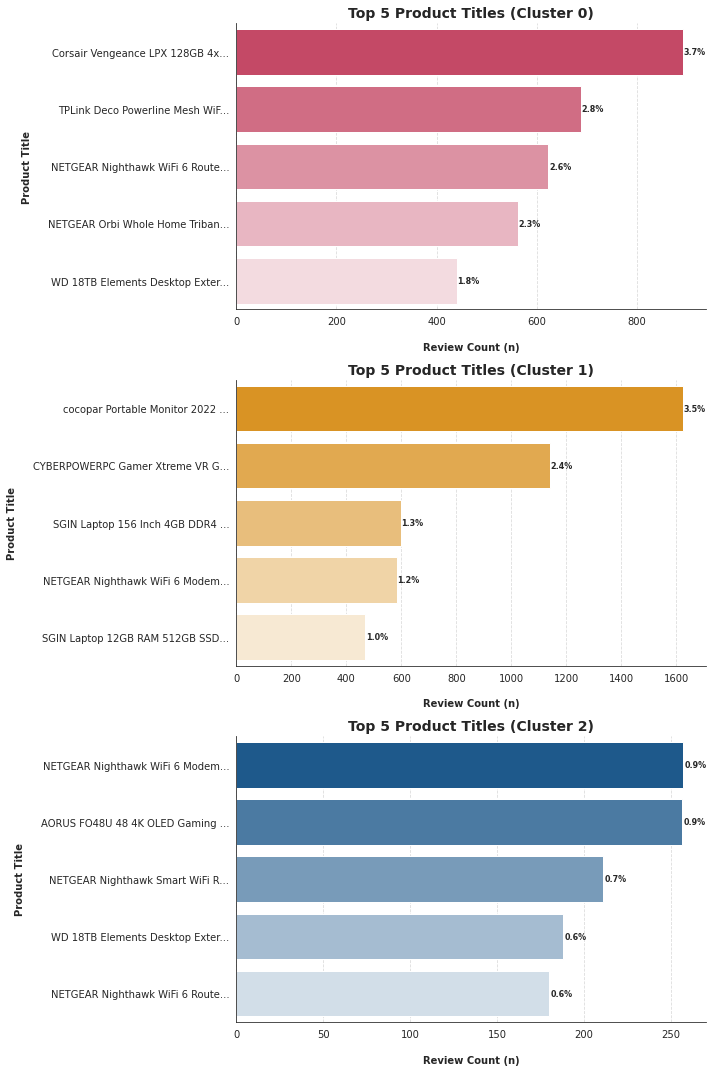

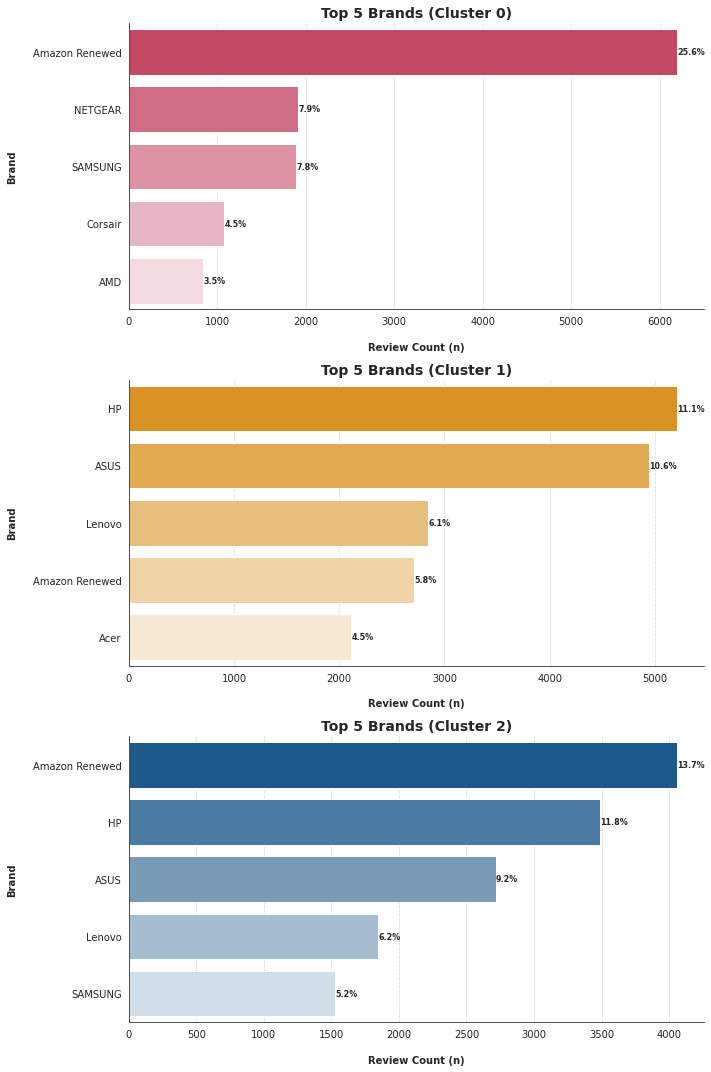

In [0]:
# ============================================
#      Top 25 Product Titles and Brands by Cluster
# ============================================
# Create a custom diverging colormap for each cluster (faded cluster color to full cluster color)
cluster_cmaps = {
    cluster: LinearSegmentedColormap.from_list(
        f"custom_{cluster}", 
        ['#FFFFFF', color],  # Start from white to full color
        N=256
    ) for cluster, color in cluster_color.items()
}
# Function to get top N items per cluster
def get_top_n_per_cluster(df, col, n=5):
    # Define a window partitioned by cluster, ordered by count descending
    window_spec = Window.partitionBy("cluster").orderBy(F.desc("count"))
    
    # Group by cluster and column, count, and rank within each cluster
    ranked_df = (df.groupBy("cluster", col)
                 .count()
                 .withColumn("rank", rank().over(window_spec))
                 .filter(F.col("rank") <= n)
                 .select("cluster", col, "count"))
    
    return ranked_df.toPandas()

# Function to get total review counts per cluster for a column
def get_cluster_totals(df, col):
    return (df.filter(F.col(col).isNotNull())
            .groupBy("cluster")
            .agg(F.sum("count").alias("total_count"))
            .toPandas()
            .set_index("cluster")["total_count"]
            .to_dict())

# Function to truncate labels
def truncate_label(label, max_length=30):
    return str(label)[:max_length] + "..." if len(str(label)) > max_length else str(label)

# Get top 5 product titles and brands per cluster
top_product_titles = get_top_n_per_cluster(clustered_df, "product_title", n=5)
top_brands = get_top_n_per_cluster(clustered_df, "meta_store", n=5)

# Get total review counts per cluster for products and brands
product_totals = get_cluster_totals(clustered_df.groupBy("cluster", "product_title").count(), "product_title")
brand_totals = get_cluster_totals(clustered_df.groupBy("cluster", "meta_store").count(), "meta_store")

# Plot top 5 product titles per cluster
fig, axes = plt.subplots(len(clusters), 1, figsize=(10, 15), sharey=False)
for i, cluster in enumerate(clusters):
    df_cluster = top_product_titles[top_product_titles['cluster'] == cluster]
    
    # Check if df_cluster is empty
    if df_cluster.empty:
        axes[i].text(0.5, 0.5, f"No data for Cluster {cluster}", 
                     ha='center', va='center', fontsize=12, color='red')
        axes[i].set_title(f"Top 5 Product Titles (Cluster {cluster})", fontsize=14, fontweight='bold')
        axes[i].set_xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
        axes[i].set_ylabel("Product Title\n", fontsize=10, fontweight='bold')
        continue
    
    # Truncate product titles
    df_cluster['product_title_truncated'] = df_cluster['product_title'].apply(truncate_label)

    # Generate color palette from the cluster's colormap
    n_bars = len(df_cluster) + 1
    colors = [cluster_cmaps[cluster](i / (n_bars - 1)) for i in range(n_bars)][1:][::-1] if n_bars > 0 else [cluster_color[cluster]]
    
    # Plot barplot with cluster-specific colormap
    sns.barplot(x="count", y="product_title_truncated", data=df_cluster, ax=axes[i], palette=colors)
    
    # Customize
    axes[i].set_title(f"Top 5 Product Titles (Cluster {cluster})", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
    axes[i].set_ylabel("Product Title\n", fontsize=10, fontweight='bold')
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add percentages
    total = product_totals.get(cluster, 0)
    if total > 0:
        for idx, value in enumerate(df_cluster['count']):
            percentage = (value / total) * 100
            axes[i].text(value + 1, idx, f"{percentage:.1f}%", va='center', fontsize=8, fontweight='bold')

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

# Plot top 5 brands per cluster
fig, axes = plt.subplots(len(clusters), 1, figsize=(10, 15), sharey=False)
for i, cluster in enumerate(clusters):
    df_cluster = top_brands[top_brands['cluster'] == cluster]
    
    # Check if df_cluster is empty
    if df_cluster.empty:
        axes[i].text(0.5, 0.5, f"No data for Cluster {cluster}", 
                     ha='center', va='center', fontsize=12, color='red')
        axes[i].set_title(f"Top 5 Brands (Cluster {cluster})", fontsize=14, fontweight='bold')
        axes[i].set_xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
        axes[i].set_ylabel("Brand\n", fontsize=10, fontweight='bold')
        continue
    
    # Truncate brand names
    df_cluster['meta_store_truncated'] = df_cluster['meta_store'].apply(truncate_label)

    # Generate color palette from the cluster's colormap
    n_bars = len(df_cluster) + 1
    colors = [cluster_cmaps[cluster](i / (n_bars - 1)) for i in range(n_bars)][1:][::-1] if n_bars > 0 else [cluster_color[cluster]]
    
    # Plot barplot with cluster-specific colormap
    sns.barplot(x="count", y="meta_store_truncated", data=df_cluster, ax=axes[i], palette=colors)
    
    # Customize
    axes[i].set_title(f"Top 5 Brands (Cluster {cluster})", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
    axes[i].set_ylabel("Brand\n", fontsize=10, fontweight='bold')
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add percentages
    total = brand_totals.get(cluster, 0)
    if total > 0:
        for idx, value in enumerate(df_cluster['count']):
            percentage = (value / total) * 100
            axes[i].text(value + 1, idx, f"{percentage:.1f}%", va='center', fontsize=8, fontweight='bold')

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

#### **Top 5 Product Titles and Brands by Cluster**
These bar plots display the top 5 most frequently reviewed product titles and brands within each cluster, along with their percentage contribution to the cluster's total reviews for that category.

-   **Cluster 0 (Mainstream Mentions)**:
    -   **Top Brands**: Dominated by 'Amazon Renewed' (25.6%), followed by brands like NETGEAR and SAMSUNG. This aligns with the "lower-priced products, often from Amazon Renewed" characteristic.
    -   **Top Products**: Include items like "Corsair Vengeance LPX" and "TP-Link Deco Powerline Mesh WiFi," often components or peripherals.
-   **Cluster 1 (Premium Perspectives)**:
    -   **Top Brands**: Features 'HP' (11.1%), 'ASUS' (10.6%), and 'Lenovo' (6.1%), known for higher-priced electronics like laptops and gaming PCs.
    -   **Top Products**: "cocopar Portable Monitor" and "CYBERPOWERPC Gamer Xtreme VR Gaming PC" are examples, reflecting the premium nature.
-   **Cluster 2 (Critical Reviews)**:
    -   **Top Brands**: 'Amazon Renewed' is again prominent (13.7%), suggesting reconditioned items might be a source of dissatisfaction for some. 'HP' and 'ASUS' also appear, indicating that even premium brands can receive critical reviews.
    -   **Top Products**: Often specific modem/router models, which can be sources of technical frustration if they don't perform as expected.

These insights provide actionable information. For example, Amazon might investigate the quality control for "Amazon Renewed" products appearing in Cluster 2, or tailor marketing for Cluster 1 based on brand preferences for HP and ASUS.

---